In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to the network of protein-protein interactions in yeast.

In [1]:
%matplotlib inline

# utilities
import gc
import time
import os

import collections
import itertools
from importlib import reload
import pickle

# data analysis tools
import joblib
import random
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import *
import qgrid

# network analysis tools
import igraph as ig

# multiprocessing tools
import subprocess
import multiprocessing as mp

os.chdir("/home/vvi/Science/eQTL_analysis/")

# visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import networks
import qtls
import util
import ontologies

gc.enable()

%autosave 15

Autosaving every 15 seconds


## Datasets used

Take a look at readme.md in /data folder for data description. (currently unavailable)

In [2]:
random.seed(int(time.time()))

# 112 segregants genotyped by inherited marker variants
full_genotypes_df = pd.read_table("./data/genotypes/processed_genotypes.csv")

''' Where possible, gene names were converted from systematic to standard notation '''
# mRNA expression and genotypes of strains the data is available for
eQTLs_expression_df = pd.read_table("./data/eQTLs/averaged_expression.csv")
eQTLs_genotypes_df = pd.read_table("./data/eQTLs/processed_genotypes.csv")
eQTLs_genotypes_df.drop_duplicates("SNP", inplace=True)
# Protein expression and genotypes of strains the data is available for 
pQTLs_expression_df = pd.read_table("./data/pQTLs/averaged_expression.csv")
pQTLs_genotypes_df = pd.read_table("./data/pQTLs/processed_genotypes.csv")
pQTLs_genotypes_df.drop_duplicates("SNP", inplace=True)

# pandas DataFrame —> numpy matrix = 2x speedup
pQTLs_expression_mx = pQTLs_expression_df.as_matrix(columns=pQTLs_expression_df.columns[1:])
pQTLs_genotypes_mx = pQTLs_genotypes_df.as_matrix(columns=pQTLs_genotypes_df.columns[1:])

# QTLs estimated with MatrixEQTL package for R
eQTLs_df = pd.read_table("./data/eQTLs/results.csv")
eQTLs_df = eQTLs_df[eQTLs_df["q.value"] <= 0.05]
pQTLs_df = pd.read_table("./data/pQTLs/results.csv")
pQTLs_df = pQTLs_df[pQTLs_df["q.value"] <= 0.05]

# Physical and genetic interactions taken from TheBioGrid project
full_interactome_df = pd.read_table("./data/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[full_interactome_df['Publication year'] <= 2011]

'''
Move these to their project part, there is no need for them anywhere else
'''
genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association",
    "colocalization",   
    "direct interaction",
    "physical association"
]

interaction_categories = genetic_interaction_categories + physical_interaction_categories
interactome_df = full_interactome_df.copy()
interactome_df.set_index('Interaction Type', inplace=True)
genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

# Genetic nomenclature and mappings between different naming conventions (official lookup table)
gene_nomenclature_df = pd.read_table("./data/nomenclature/yeast_gene_nomenclature_mapping.csv")
gene_nomenclature_df.drop_duplicates("Systematic name", inplace=True)

std_to_sys = dict(zip(
    gene_nomenclature_df["Standard name"].values, 
    gene_nomenclature_df["Systematic name"].values
))
sys_to_std = {v: k for k, v in std_to_sys.items()}

# Functional modules found in PPI graph  
# according to the data published at http://thecellmap.org/costanzo2016/
thecellmap_modules_df = pd.read_table("./data/interactions/bioprocess_annotations_costanzo2016.csv")
thecellmap_module_names = [s.replace('/', '|') for s in np.unique(thecellmap_modules_df["Function"].values)]

def extract_interactions(interactions_df):
    ''' Helper function to retrieve the edges of the graph of interactions '''
    return interactions_df[["Interactor A", "Interactor B"]].values

interaction_graphs_dict = {}
for category_name in interaction_categories:
    interacting_genes_df = interactome_df[interactome_df.index == category_name]
    interaction_graphs_dict[category_name] = networks.graph_from_edges(
        extract_interactions(interacting_genes_df),
    )
    
interaction_graphs_dict.update(dict(zip(["all", "genetic", "physical"],
    itertools.starmap(networks.graph_from_edges, 
        [(extract_interactions(interactome_df), False, False),
         (extract_interactions(genetic_interactions_df), False, False), 
         (extract_interactions(physical_interactions_df), False, False)]
    )))
)

## Introduction and problem formulation

The plot below compares the distributions of eQTLs (blue) and pQTLs (yellow) in the yeast genome. Many hotspots are common, but effect sizes differ.  
**TODO:** Обозначить отрезки хромосом на оси геномных координат.

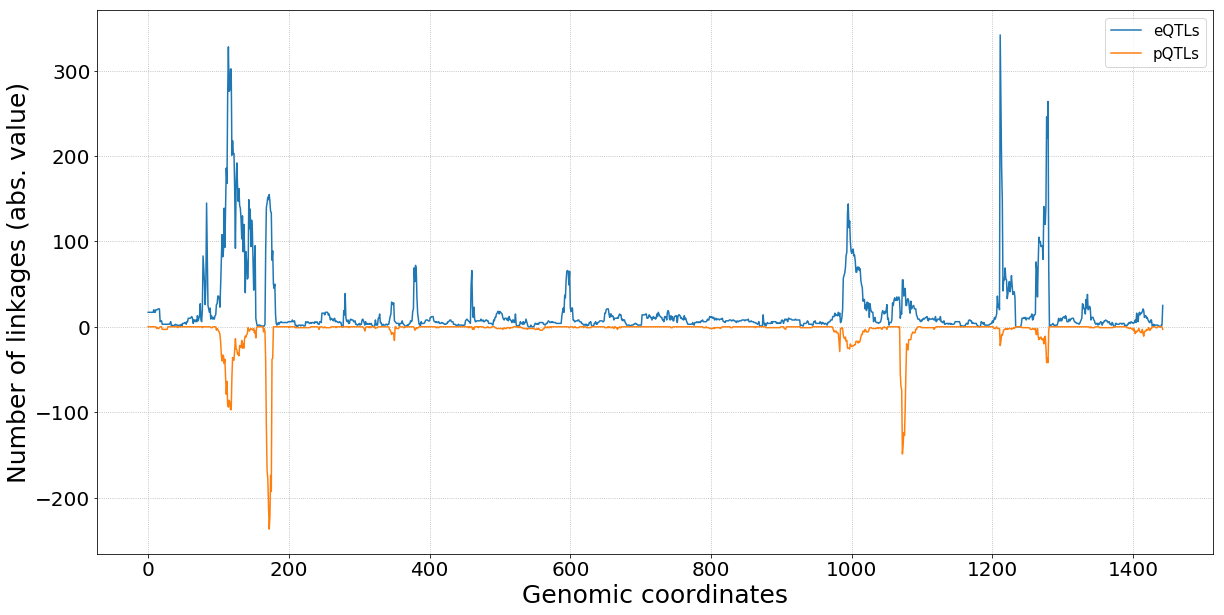

In [78]:
eQTL_y = np.array(qtls.linkages2gencoords(eQTLs_df, full_genotypes_df)[1])
pQTL_y = np.array(qtls.linkages2gencoords(pQTLs_df, full_genotypes_df)[1])

plt.figure(figsize=(20, 10))
plt.plot(eQTL_y, label="eQTLs")
plt.plot(-pQTL_y, label="pQTLs")
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=15)
plt.grid(linestyle="dotted")
plt.savefig("./img/linkages/eQTLs_pQTLs_combined.png", dpi=300)


Both eQTLs and pQTLs were computed from expression data using [MatrixEQTL](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3348564/) — a tool for R programming language.  
The same results very also previously obtained using naive approach: just take all (marker, gene) pairs, divide expression into groups by inhertied polymorphism, calculate the p-value using MWU test and do FDR-correctness with [q-value](https://github.com/StoreyLab/qvalue) package.  
Results can be viewed separately on graphs below.

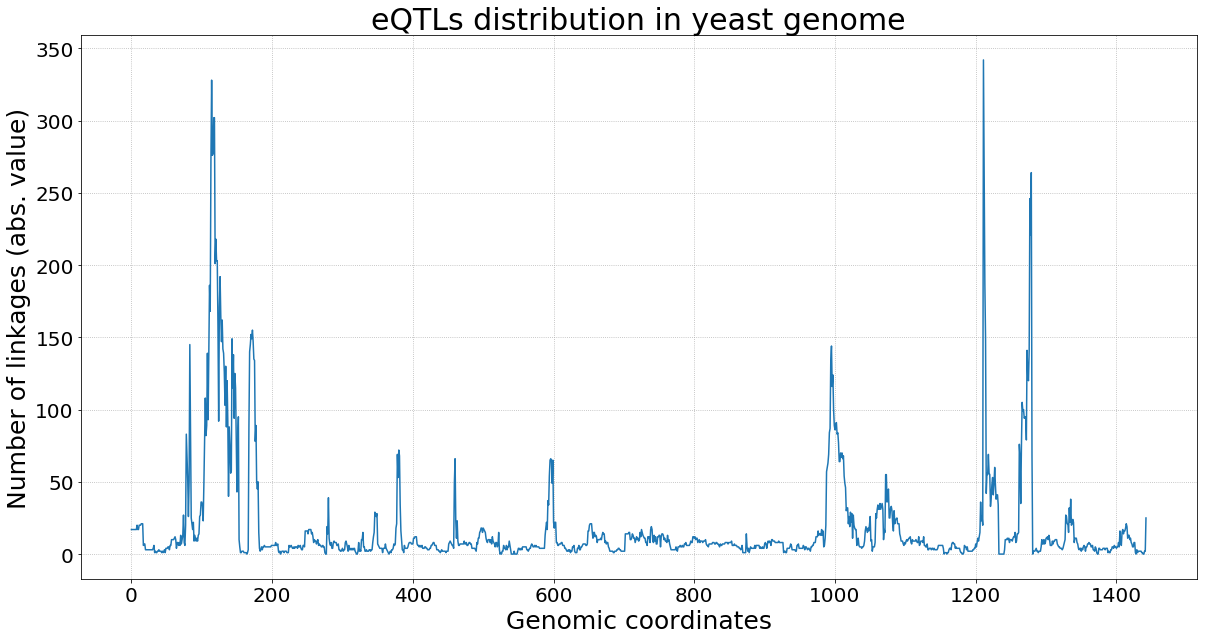

In [9]:
plt.figure(figsize=(20, 10))
plt.plot(eQTL_y)
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.title("eQTLs distribution in yeast genome", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(linestyle="dotted")
plt.show()
plt.close()

%reset_selective eQTL_y

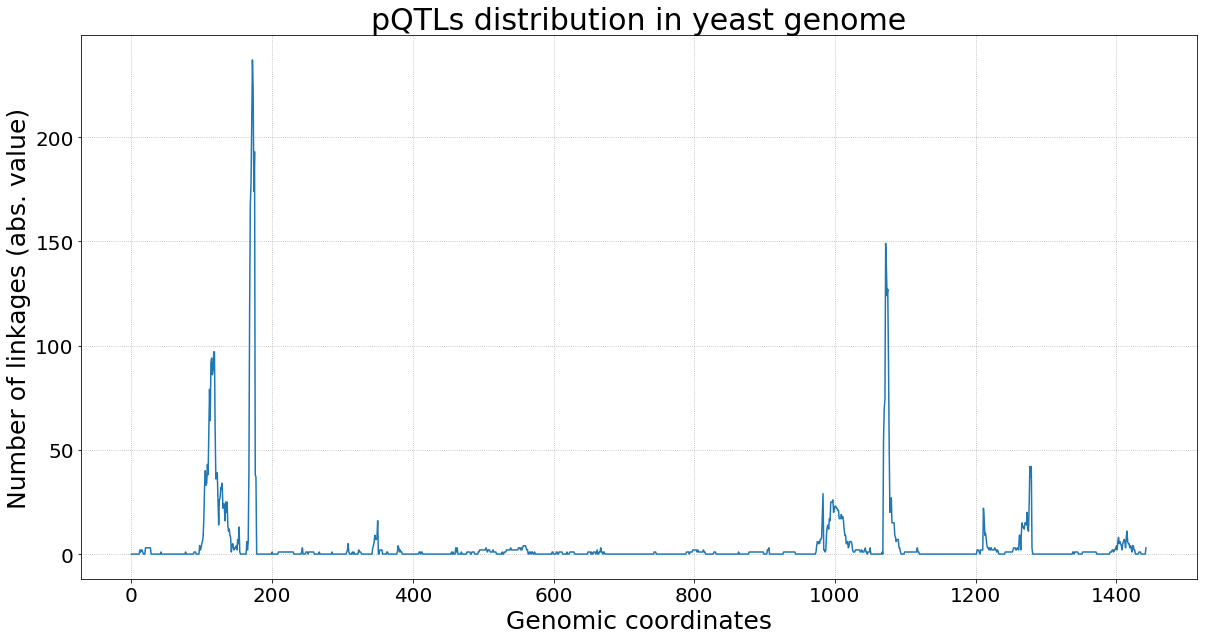

In [10]:
plt.figure(figsize=(20, 10))
plt.plot(pQTL_y)
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.title("pQTLs distribution in yeast genome", fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(linestyle="dotted")
plt.show()
plt.close()

%reset_selective pQTL_y

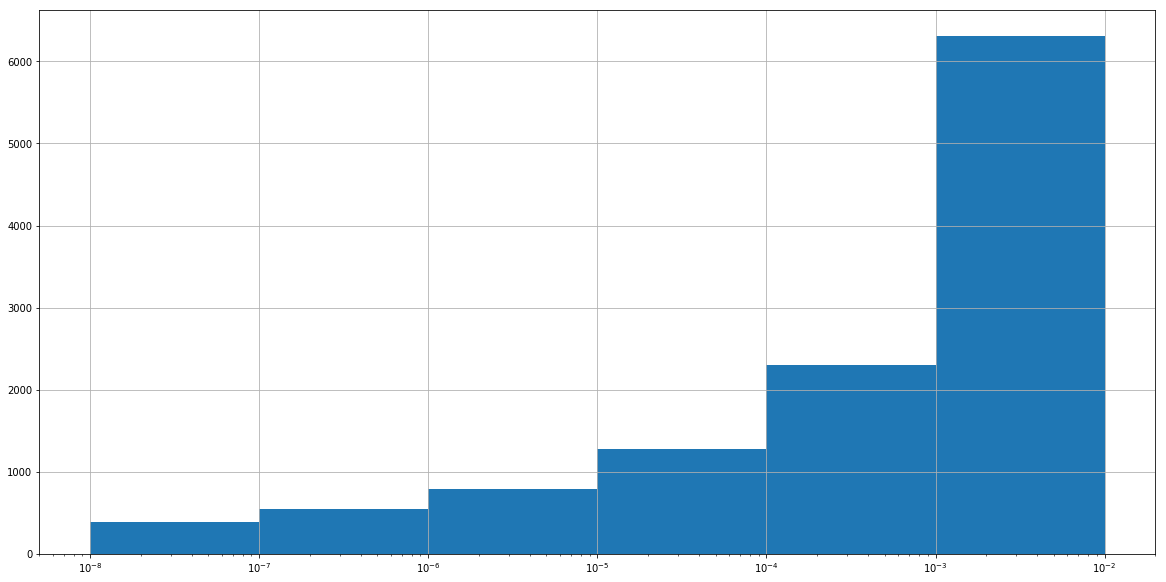

In [152]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.xscale('log')
count, bins, patches = plt.hist(eQTLs_df["q.value"], bins=10.**np.arange(-8, -1))
plt.xticks(bins)
plt.grid()
plt.show()
plt.close()

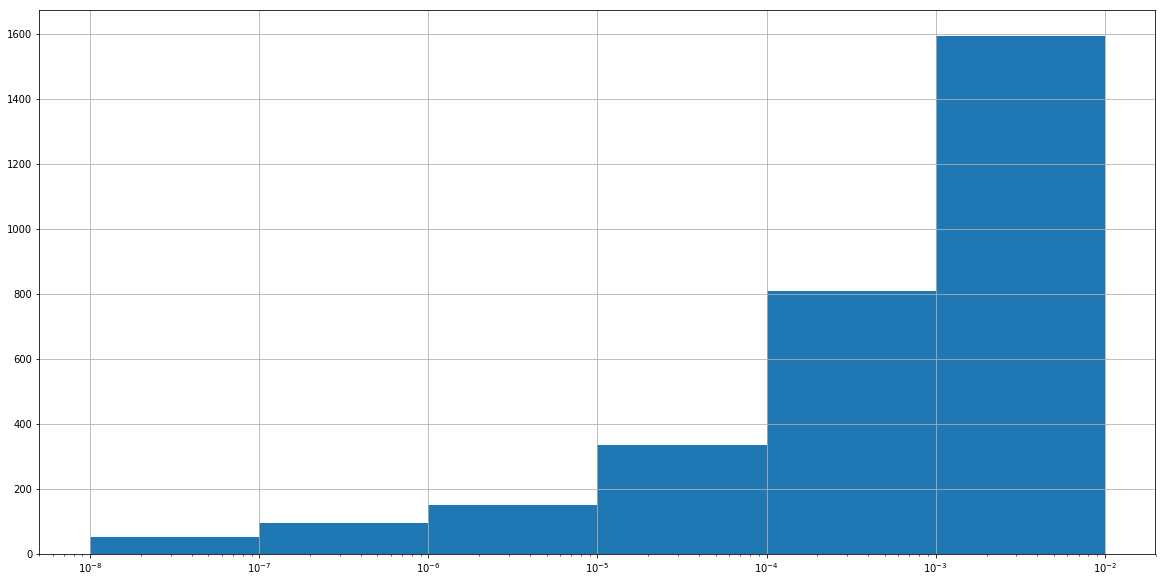

In [155]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.xscale('log')
count, bins, patches = plt.hist(pQTLs_df["q.value"], bins=10.**np.arange(-8, -1))
plt.xticks(bins)
plt.grid()
plt.show()
plt.close()

It seems rational to suppose that transcription and translation levels must be controlled by similar genetic mechanisms.  
Unfortunately, at the first sight there is no evidence to support that intuition: sets of eQTLs and pQTLs linked to given gene show no significant overlap for almost all genes. This is illustrated by the histogram below.

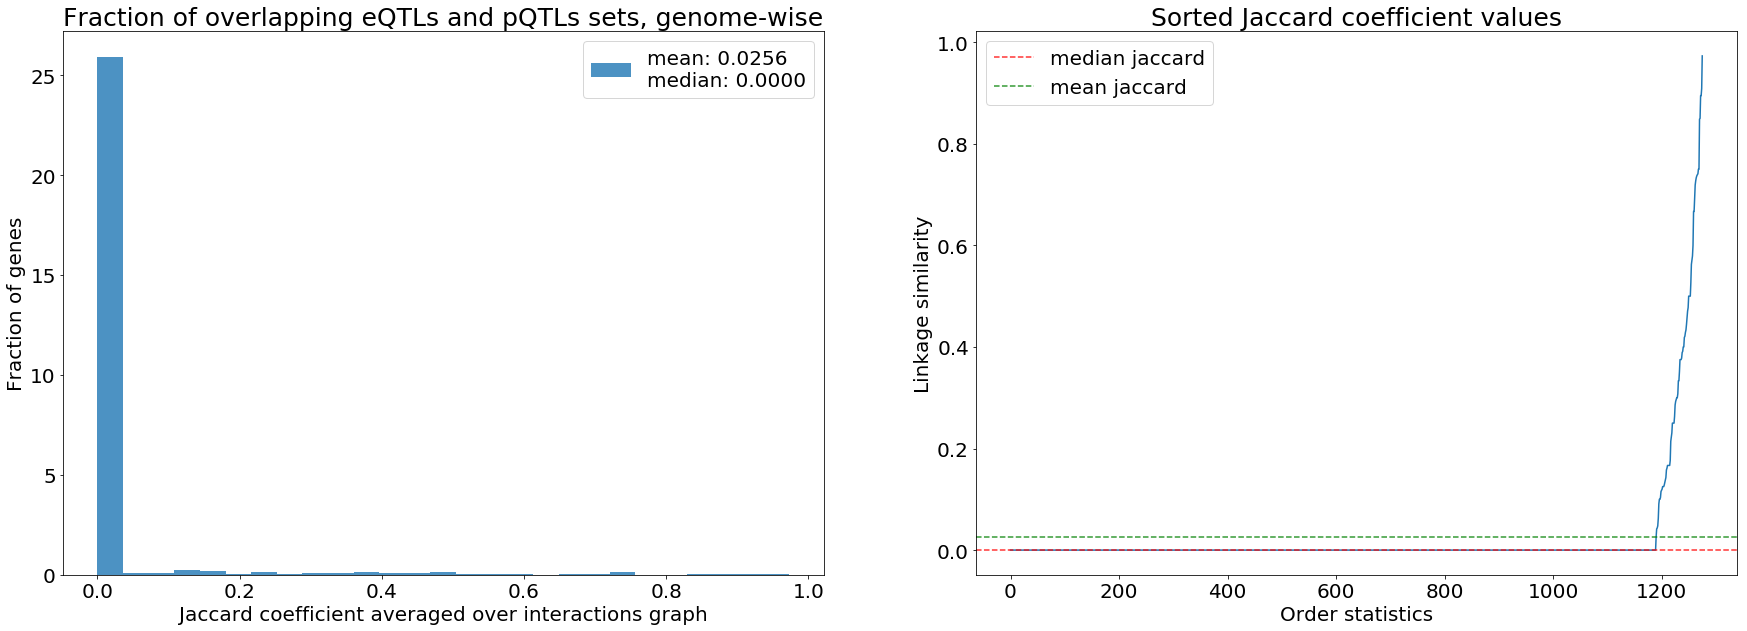

In [11]:
reload(util)
gene_pool = np.intersect1d(eQTLs_expression_df["gene"], pQTLs_expression_df["gene"])

linkage_overlap_data = []
for gene_name in gene_pool:
    linked_eQTLs = qtls.linked_markers(eQTLs_df, [gene_name])
    linked_pQTLs = qtls.linked_markers(pQTLs_df, [gene_name])
    linkage_overlap_data.append(qtls.jaccard(set(linked_eQTLs), set(linked_pQTLs)))
    
qtls.qtl_overlap_hist(linkage_overlap_data, "eQTLs_pQTLs")


Hypothesis arises: maybe not single genes, but functional modules tend to share linkages.  
The goal of this work is to test that hypothesis using yeast interactome data.

## Interacting genes tend to share linkage: bird's eye view.

First, it can be shown that interacting genes tend to share linkages.  
To establish that the following procedure was used:   
- Generate 1000 FDR-cutoffs in range 1e-8...1e-2
- For each threshold:
	- Select subset of significant QTLs according to given threshold
	- Divide interactions into categories and extract corresponding subgraphs
	- Perform subgraph clusterization and calculate mean Jaccard coefficient between eQTL- and pQTL-linkage sets for each cluster. Average of those is taken to be mean linkage similarity measure. No sophisticated clustering is used at the moment: each edge forms its own cluster. Nevertheless, this proves to be sufficient to show statistically significant dependence.
	- In order to ensure that observed linkage similarity is not an artefact of interactions graph structure and not its biological meaning, those graphs are randomized preserving degree sequence and analyzed in the same manner.


In [92]:
%%time

''' NO NEED IN MODULE GRAPH PLOTS. TIME CONSUMING, SEND TO CLUSTER. '''

for expression_df, qtl_df, qtl_type in [(eQTLs_expression_df, eQTLs_df, "eQTLs"), 
                                        (pQTLs_expression_df, pQTLs_df, "pQTLs")]:
    module_graph_analyzer = qtls.LinkageSharingAnalyzer(
        expression_df=expression_df,
        interactome_graph=interaction_graphs_dict["physical"],
        qtl_type=qtl_type,
        qtl_df=qtl_df,
        modules_type="thebiogrid",
        module_dict={module_name : module_graph.vs["name"] 
                     for module_name, module_graph in interaction_graphs_dict.items()},
        q_thresholds=np.logspace(-5, -2, 10),
        pairwise_test_iter=32,
        ppi_test_iter=1024
    ).process_modules()

    qtls.plot_vignettes(module_type="thebiogrid", module_names=interaction_graphs_dict.keys())

all


association


additive genetic interaction defined by inequality


physical association


direct interaction


colocalization


physical


suppressive genetic interaction defined by inequality


genetic


synthetic genetic interaction defined by inequality


Process ForkPoolWorker-70:


Process ForkPoolWorker-72:


Process ForkPoolWorker-66:


Process ForkPoolWorker-71:


Process ForkPoolWorker-68:


Process ForkPoolWorker-65:


Traceback (most recent call last):


  File "/home/vvi/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


Traceback (most recent call last):


  File "/home/vvi/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/home/vvi/anaconda3/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/vvi/anaconda3/lib/python3.5/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))


Traceback (most recent call last):


Traceback (most recent call last):


  File "/home/vvi/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


  File "/home/vvi/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


  File "/home/vvi/Science/eQTL_analysis/lib/qtls.py", line 531, in _pairwise_process_threshold
    randsum += linkage_similarity(full_g, qtl_graph, mode='mean')


KeyboardInterrupt


  File "/home/vvi/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


  File "/home/vvi/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


  File "/home/vvi/Science/eQTL_analysis/lib/qtls.py", line 268, in linkage_similarity
    t_neigh = set(qtl_graph.neighbors(target["name"], mode="IN"))


  File "/home/vvi/anaconda3/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()


  File "/home/vvi/anaconda3/lib/python3.5/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))


  File "/home/vvi/anaconda3/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)


## Predicting pQTLs from eQTLs using PPI networks

Now, when approach using interaction networks is justified, it's time to provide solid ground: if significant fraction of pQTLs can be rediscovered from eQTLs linked to genes interacting with given (including itself), it will serve as an additional evidence for hypothesis being actually true (once again, no sophisticated clustering was performed here, while it would possibly yield better results).  

The main idea is not to test all (marker, gene) pairs but to filter for trusted only. In order to get rid of the pairs that will not link (or at least to dump more false than real linkages), the following approach is proposed: 
1. For each gene with measured protein abundance select its eQTL linkages as candidates into pQTLs. 
2. Extend eQTL linkages with those of the interacting genes. 

FDR decreases for the same q-value threshold, which results in more trustworthy observations.

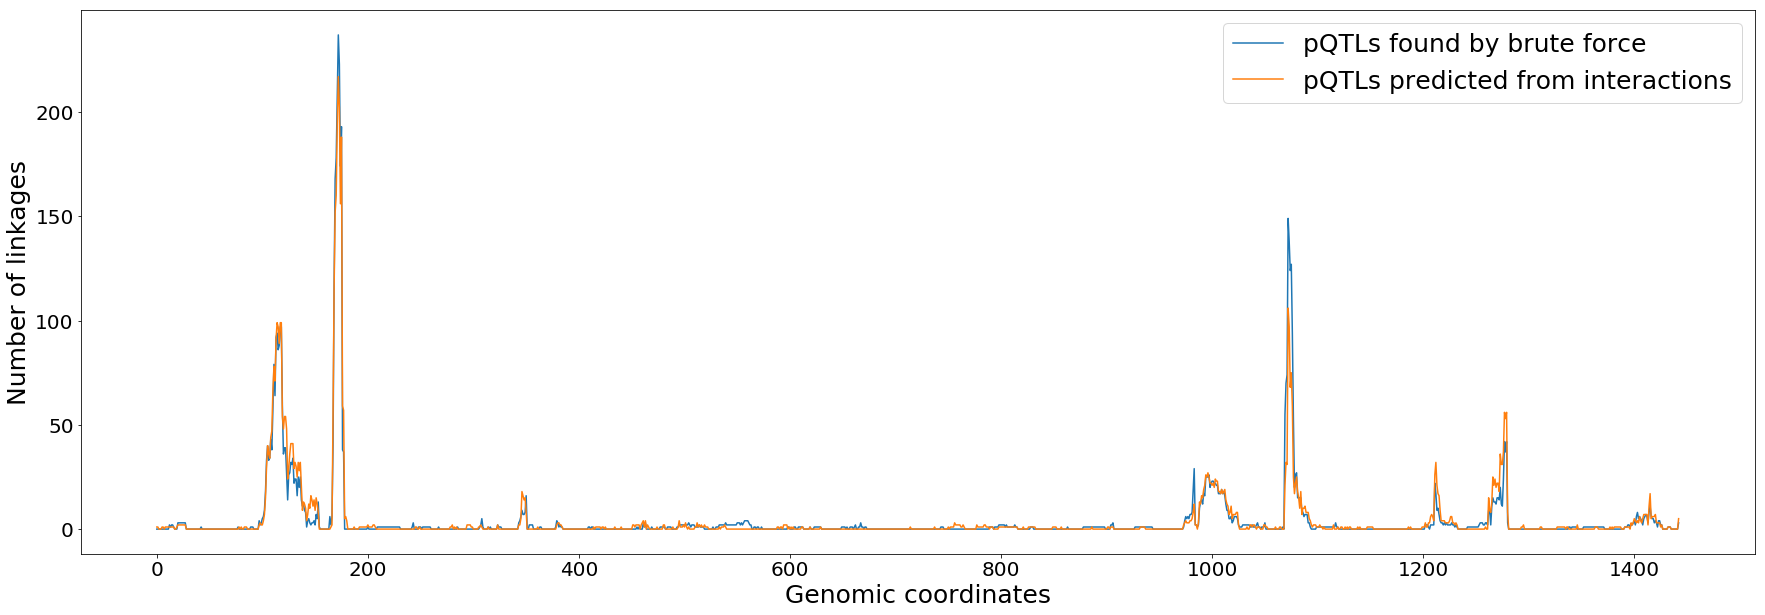

In [7]:
pqtl_finder = qtls.PqtlPredictor(
    eQTLs_df, pQTLs_df,
    eQTLs_expression_df, eQTLs_genotypes_df,
    pQTLs_expression_df, pQTLs_genotypes_df,
    full_genotypes_df,
    "full interactome",
    networks.graph_from_edges(extract_interactions(interactome_df))
)

results = pqtl_finder.predict()

%reset_selective pqtl_finder

Here is some statistics computed from some subgraphs of the interactome. 

**Physical interactions only**:   
- Common linkages: 2021, 32.7977929243752%
- Old linkages, total: 6162
- New linkages, total: 4048
- New linkages found: 2027

**Full interactome**:
- Common linkages: 3688, 59.85069782538137%
- Old linkages, total: 6162
- New linkages, total: 6219
- New linkages found: 2531

It becomes evident, that a significant fraction of estimated pQTLs can be reproduced using this approach.  
**Nevertheless, many questions arise**:
- Which fraction of trans-pQTLs is reproduced? (and is this approach capable of detecting those)
- Are all the hotspots reproduced? If some are not, why then? It is worth mentioning, that some of those were given cryptic names which are nowhere to be found. 
- How robust the results are? So far results are not compared with those computed from simulated, perturbed graphs. 

## Interacting genes tend to share linkages: analysis of coarse-grained functional modules

The problem is, interaction types given in the BioGrid database are too general from the biological viewpoint.  
It's worth investigating in more detail, which biological processes demonstrate statistically significant link between regulation mechanisms of different expression types.  
In order to do so, curated functional modules taken from the ["Global Genetic Interaction Dataset"](http://thecellmap.org/costanzo2016) (University of Toronto) are tested, among those:
- Cell polarity & morphogenesis
- Cytokinesis
- DNA replication & repair
- Glycosylation, protein folding|targeting, cell wall biosynthesis
- MVB sorting and pH depending signaling
- Metabolism
- Mitosis & chromosome segregation
- Nuclear-cytoplasmic transport
- Peroxisome
- Protein degradation|turnover
- Respiration, oxidative phosphorylation, mitochondrial targeting
- Ribosome biogenesis
- Transcription & chromatin organization
- Vesicle traffic
- mRNA & tRNA processing
- rDNA & ncDNA processing
- tRNA wobble modification

**All images from this section can be found in /img/functional_module_graphs/ and /img/linkage_sharing/thecellmap directories.**

In [186]:
%%time

'''
    Randomize the interactome graph 1024 times and save each version. These randomized copies will be used throughout the project.
'''

def _produce_randomized_interactome_copy(i):
    randomized_interactome = interaction_graphs_dict["physical"].Degree_Sequence(
        interaction_graphs_dict["physical"].degree(),
        method='vl'
    )
    randomized_interactome.vs["name"] = interaction_graphs_dict["physical"].vs["name"]
    ig.write(
        graph=randomized_interactome,
        filename="./data/randomized_interactome_copies/{}.pkl".format(i),
        format="pickle"
    )

pool = mp.Pool(mp.cpu_count())
pool.map(_produce_randomized_interactome_copy, range(1024))
pool.close()
pool.join()

CPU times: user 608 ms, sys: 244 ms, total: 852 ms
Wall time: 14min 40s


In [12]:
thecellmap_modules_dict = {}
for module_name in thecellmap_module_names:
    thecellmap_modules_dict[module_name] = thecellmap_modules_df[
        thecellmap_modules_df["Function"].str.contains(module_name)
    ]["Interactor (std)"].values
    
thecellmap_modules_dict["all"] = np.unique(np.hstack(thecellmap_modules_dict.values())) 

In [79]:
%%time

for simplify_flag in [False, True]:
     display(networks.basic_module_info(
         interactome_graph=interaction_graphs_dict["all"], 
         modules_dict=thecellmap_modules_dict, 
         modules_type="thecellmap",
         simplify=simplify_flag).sort_values(by="genes count", ascending=False))

,module name,genes count,genes with interactions,interactions count
0,Mitosis & chromosome segregation,199,149,11576
11,"Glycosylation, protein folding|targeting, cell...",160,140,8640
1,"Respiration, oxidative phosphorylation, mitoch...",138,136,1206
15,Transcription & chromatin organization,110,85,6054
4,Cell polarity & morphogenesis,102,64,3118
7,mRNA & tRNA processing,96,84,3437
6,Vesicle traffic,95,85,6108
13,DNA replication & repair,95,75,3605
14,rDNA & ncDNA processing,90,76,2107
3,Ribosome biogenesis,74,71,251


,module name,genes count,genes with interactions,interactions count
0,Mitosis & chromosome segregation,199,149,4198
11,"Glycosylation, protein folding|targeting, cell...",160,140,3870
1,"Respiration, oxidative phosphorylation, mitoch...",138,133,752
15,Transcription & chromatin organization,110,85,1917
4,Cell polarity & morphogenesis,102,64,979
7,mRNA & tRNA processing,96,83,1458
6,Vesicle traffic,95,85,2005
13,DNA replication & repair,95,75,1228
14,rDNA & ncDNA processing,90,76,982
3,Ribosome biogenesis,74,67,170


CPU times: user 12.5 s, sys: 24 ms, total: 12.5 s
Wall time: 12.5 s


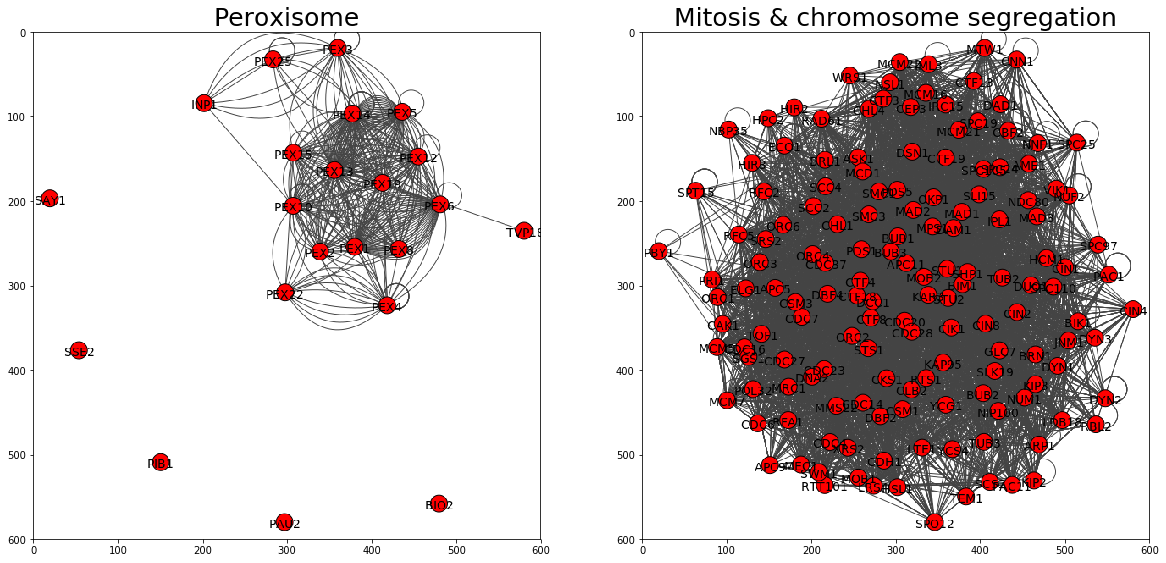

In [80]:
f, axarr = plt.subplots(1, 2, figsize=(20,20))
axarr[0].imshow(plt.imread("./img/functional_module_graphs/thecellmap/raw/Peroxisome.png"))
axarr[0].set_title("Peroxisome", fontsize=25)
axarr[1].imshow(plt.imread("./img/functional_module_graphs/thecellmap/raw/Mitosis & chromosome segregation.png"))
axarr[1].set_title("Mitosis & chromosome segregation", fontsize=25)
plt.show()


It's clear from the data above, that most of the modules are tiny (65 vertices on average) compared to whole interactome which comprises of **6611 vertices** and **681490 edges**.  
There even are clusters on 4, 11 and 14 vertices. The owerwhelming amount of multiedges and loops is also worth mentioning.  
Removing those drastically reduces the modules' sizes, as is shown below.

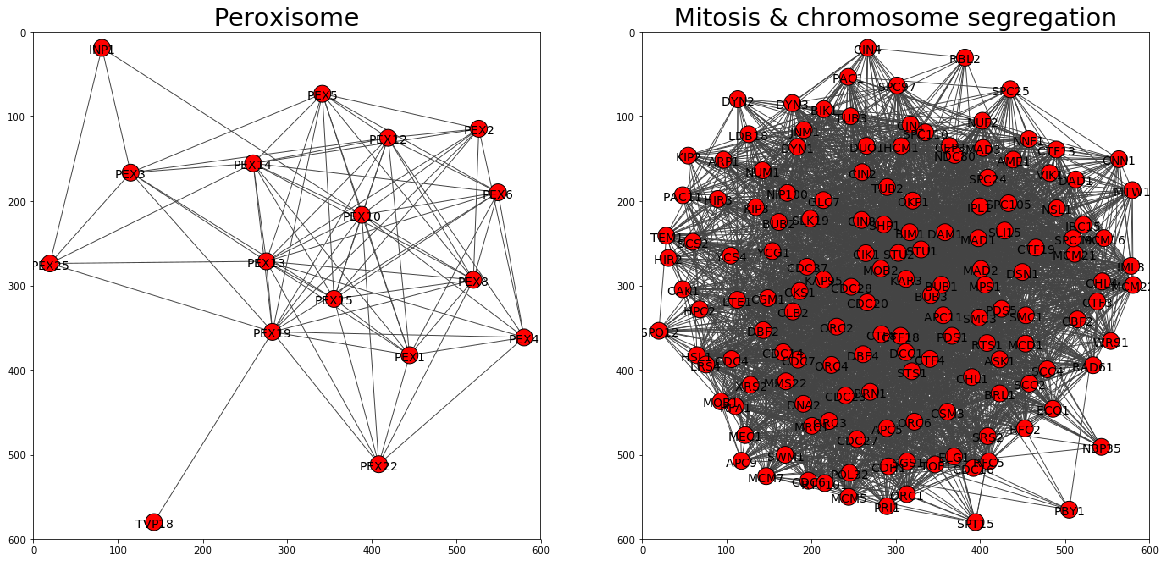

In [81]:
f, axarr = plt.subplots(1, 2, figsize=(20,20))
axarr[0].imshow(plt.imread("./img/functional_module_graphs/thecellmap/simplified/Peroxisome.png"))
axarr[0].set_title("Peroxisome", fontsize=25)
axarr[1].imshow(plt.imread("./img/functional_module_graphs/thecellmap/simplified/Mitosis & chromosome segregation.png"))
axarr[1].set_title("Mitosis & chromosome segregation", fontsize=25)
plt.show()

%reset_selective .*module_graphs_dict

In [119]:
%%time

reload(networks)
reload(qtls)

results_df = {}
for expression_df, qtl_df, qtl_type in [(eQTLs_expression_df, eQTLs_df, "eQTLs"),
                                        (pQTLs_expression_df, pQTLs_df, "pQTLs")]:
    results_df[qtl_type] = qtls.LinkageSharingAnalyzer(
        expression_df=expression_df,
        interactome_graph=interaction_graphs_dict["physical"],
        modules_type="thecellmap",  
        module_dict={"all":thecellmap_modules_dict["all"]},
        qtl_type=qtl_type,
        qtl_df=qtl_df,
        q_thresholds=np.logspace(-5, -2, 10),
        pairwise_test_iter=200,
        ppi_test_iter=16
    ).process_modules()

qtls.plot_vignettes(module_type="thecellmap", module_names=thecellmap_modules_dict.keys())

Metabolism


tRNA wobble modification


Nuclear-cytoplasmic transport


Mitosis & chromosome segregation


Glycosylation, protein folding|targeting, cell wall biosynthesis


MVB sorting and pH depending signaling


Ribosome biogenesis


Protein degradation|turnover


all


Transcription & chromatin organization


Cytokinesis


rDNA & ncDNA processing


Cell polarity & morphogenesis


mRNA & tRNA processing


Vesicle traffic


DNA replication & repair


Peroxisome


Respiration, oxidative phosphorylation, mitochondrial targeting


CPU times: user 1min 13s, sys: 1.8 s, total: 1min 15s
Wall time: 39min 46s


In [42]:
%%time 
# gene_pool = np.intersect1d(eQTLs_expression_df["gene"], pQTLs_expression_df["gene"])
gene_pool = np.union1d(eQTLs_df["gene"], pQTLs_df["gene"])

thecellmap_intersection_j, thecellmap_randomized_intersection_j = \
    qtls.qtl_overlap_test(eQTLs_df, pQTLs_df, gene_pool, thecellmap_modules_dict)

random samples generated:   0%|          | 0/18 [00:00<?, ?it/s]

random samples generated:   6%|▌         | 1/18 [00:00<00:08,  2.01it/s]

random samples generated:  11%|█         | 2/18 [00:00<00:06,  2.31it/s]

random samples generated:  17%|█▋        | 3/18 [00:01<00:05,  2.51it/s]

random samples generated:  22%|██▏       | 4/18 [00:01<00:05,  2.35it/s]

random samples generated:  28%|██▊       | 5/18 [00:02<00:05,  2.40it/s]

random samples generated:  33%|███▎      | 6/18 [00:02<00:04,  2.43it/s]

random samples generated:  39%|███▉      | 7/18 [00:02<00:04,  2.48it/s]

random samples generated:  44%|████▍     | 8/18 [00:03<00:04,  2.40it/s]

random samples generated:  50%|█████     | 9/18 [00:03<00:03,  2.39it/s]

random samples generated:  56%|█████▌    | 10/18 [00:03<00:03,  2.50it/s]

random samples generated:  61%|██████    | 11/18 [00:04<00:02,  2.51it/s]

random samples generated:  67%|██████▋   | 12/18 [00:04<00:02,  2.56it/s]

random samples generated:  72%|███████▏  | 13/18 [00:05<00:01,  2.59it/s]

random samples generated:  78%|███████▊  | 14/18 [00:05<00:01,  2.64it/s]

random samples generated:  83%|████████▎ | 15/18 [00:06<00:01,  2.41it/s]

random samples generated:  89%|████████▉ | 16/18 [00:06<00:00,  2.46it/s]

random samples generated:  94%|█████████▍| 17/18 [00:06<00:00,  2.54it/s]

random samples generated: 100%|██████████| 18/18 [00:06<00:00,  2.60it/s]

CPU times: user 7.02 s, sys: 8 ms, total: 7.02 s
Wall time: 7.02 s


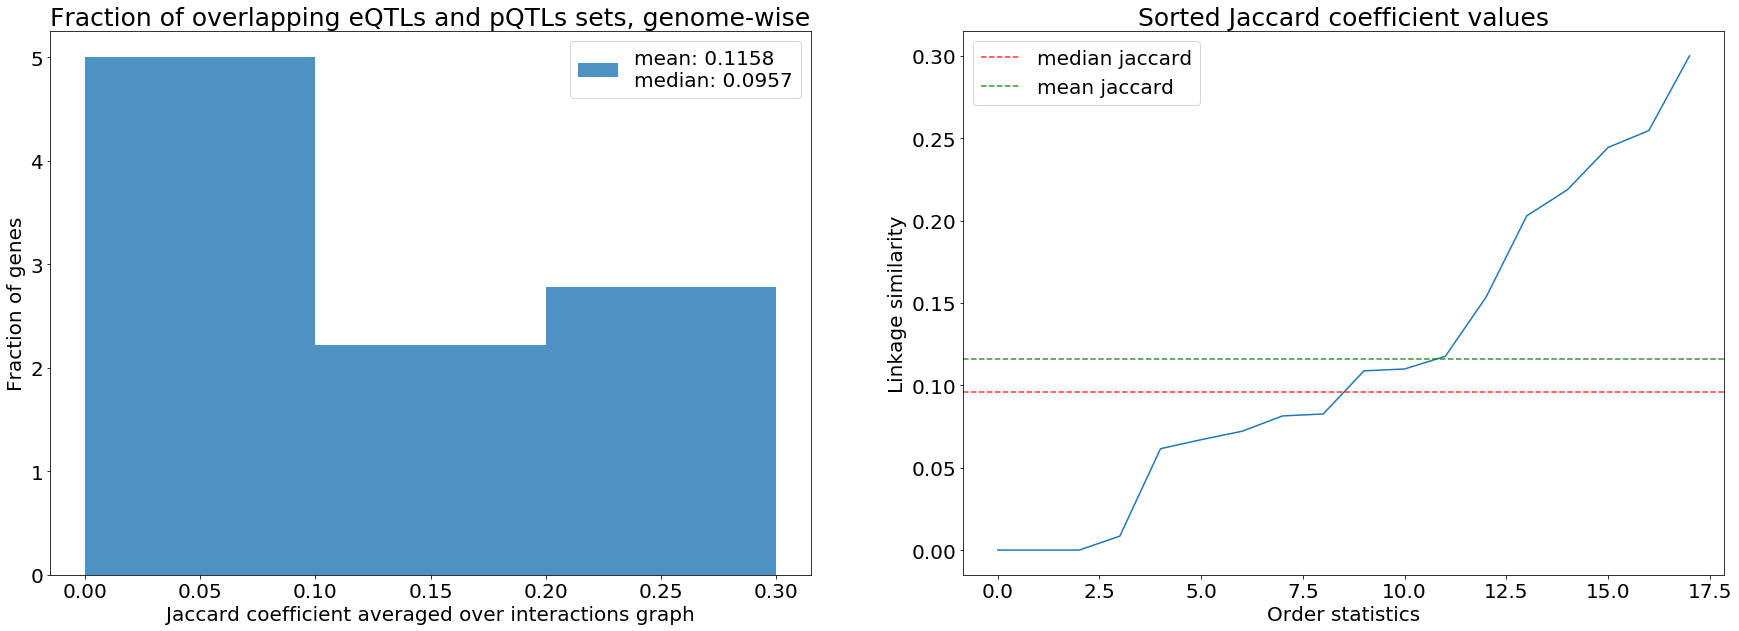

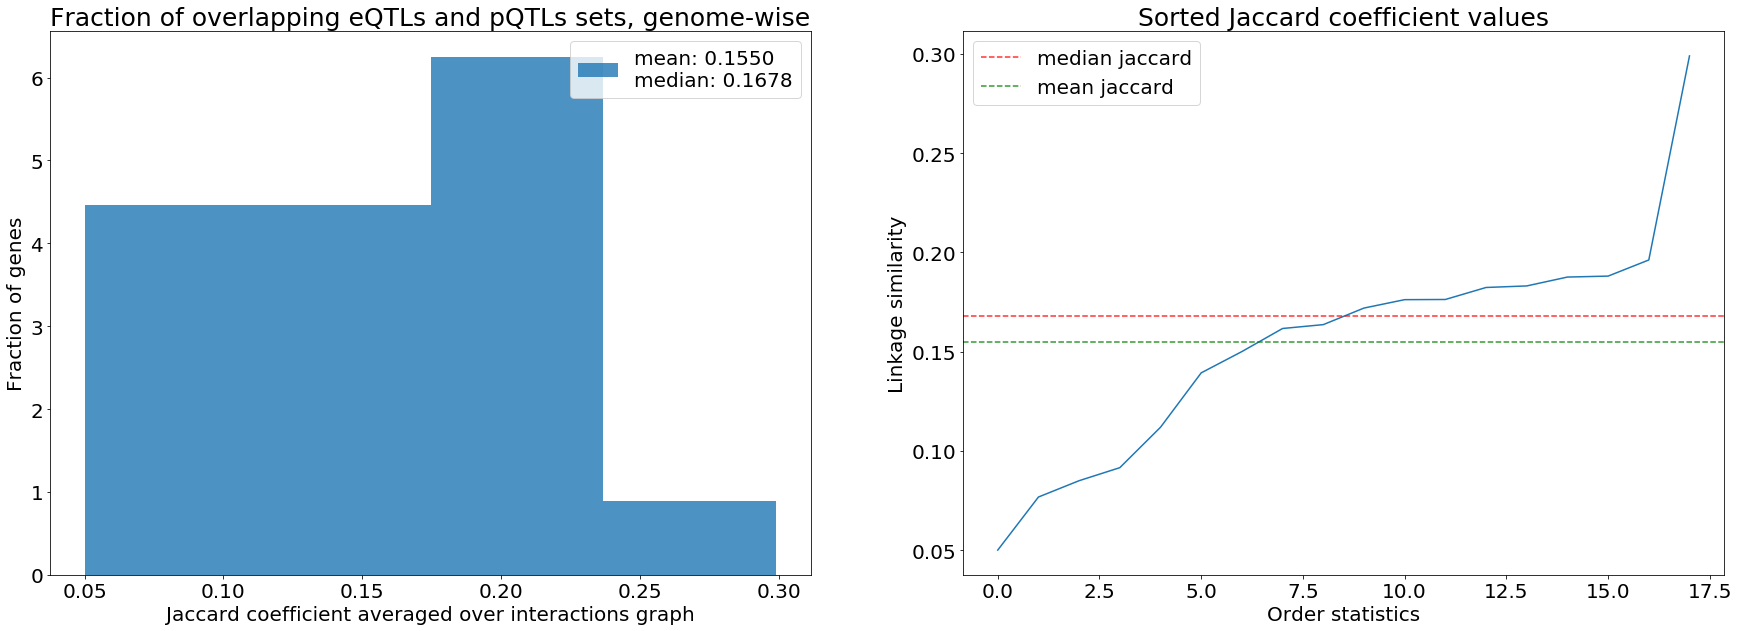

In [58]:
reload(qtls)    
    
qtls.qtl_overlap_hist(thecellmap_intersection_j, "thecellmap")
qtls.qtl_overlap_hist(thecellmap_randomized_intersection_j, "thecellmap_randomized")

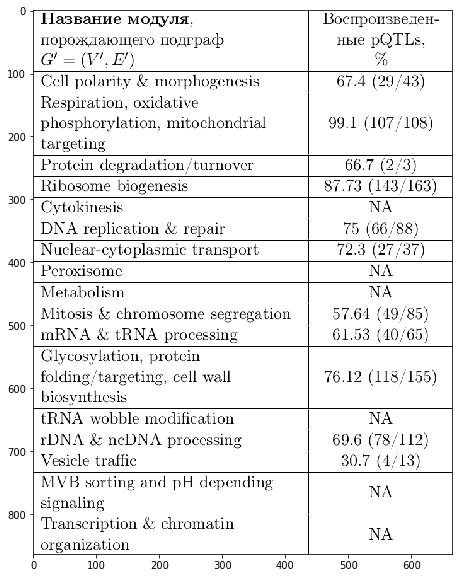

In [41]:
plt.figure(figsize=(20, 10))
plt.imshow(plt.imread("./img/illustrations/pqtl_prediction_from_modules.gif"))
plt.show(), plt.close();

## Interacting genes tend to share linkages: analysis of functional modules from GeneOntology database

In [22]:
# with open("./results/geneontology/modules_dict.pkl", "wb+") as pickle_file:
#     pickle.dump(geneontology_modules_dict, pickle_file)
with open("./results/geneontology/modules_dict.pkl", "rb+") as pickle_file:
    geneontology_modules_dict = pickle.load(pickle_file)

In [18]:
from goatools import obo_parser

# building the GeneOntology DAG
obodag = obo_parser.GODag(
    "./data/geneontology/go-basic.obo",
    optional_attrs=["relationship"]
)

./data/geneontology/go-basic.obo: fmt(1.2) rel(2018-07-02) 47,231 GO Terms; optional_attrs(relationship)


In [19]:
from Bio.UniProt.GOA import gafiterator

# how many of them are present in actual yeast genome?
yeast_gaf = './data/geneontology/goa_yeast.gaf'
goid2genes = collections.defaultdict(list)
with open(yeast_gaf) as handle:
    for rec in gafiterator(handle):
        go_term = obodag[rec["GO_ID"]]
        for par in go_term.parents:
            goid2genes[par.id].append(rec["DB_Object_Symbol"])
            
for key, val in goid2genes.items():
    goid2genes[key] = np.unique(val)


In [20]:
physically_interacting_genes = set(interaction_graphs_dict["physical"].vs["name"])
geneontology_modules_dict = {
    obodag[go_id].name.replace('/', '|') : genes 
    for go_id, genes in tqdm(goid2genes.items()) 
    if 10 <= len(interaction_graphs_dict["physical"].subgraph(
            set(genes) & physically_interacting_genes
        ).simplify().vs.select(_degree_gt=0)) <= 150
}

  0%|          | 0/4136 [00:00<?, ?it/s]

 14%|█▍        | 586/4136 [00:00<00:00, 5845.07it/s]

 32%|███▏      | 1310/4136 [00:00<00:00, 6539.82it/s]

 46%|████▌     | 1909/4136 [00:00<00:00, 6356.18it/s]

 56%|█████▋    | 2327/4136 [00:00<00:00, 5416.03it/s]

 67%|██████▋   | 2761/4136 [00:00<00:00, 5167.58it/s]

 82%|████████▏ | 3373/4136 [00:00<00:00, 5317.05it/s]

100%|█████████▉| 4135/4136 [00:00<00:00, 5630.56it/s]

100%|██████████| 4136/4136 [00:00<00:00, 5617.18it/s]

In [40]:
%%time 

# gene_pool = np.intersect1d(eQTLs_expression_df["gene"], pQTLs_expression_df["gene"])
gene_pool = np.union1d(eQTLs_expression_df["gene"], pQTLs_expression_df["gene"])

geneontology_intersection_j, geneontology_randomized_intersection_j= \
    qtls.qtl_overlap_test(eQTLs_df, pQTLs_df, 
                          gene_pool, geneontology_modules_dict)


random samples generated:   0%|          | 0/702 [00:00<?, ?it/s]

random samples generated:   0%|          | 1/702 [00:00<02:26,  4.78it/s]

random samples generated:   0%|          | 2/702 [00:00<02:35,  4.51it/s]

random samples generated:   0%|          | 3/702 [00:00<02:40,  4.36it/s]

random samples generated:   1%|          | 4/702 [00:01<02:54,  3.99it/s]

random samples generated:   1%|          | 5/702 [00:01<02:58,  3.89it/s]

random samples generated:   1%|          | 6/702 [00:01<02:59,  3.87it/s]

random samples generated:   1%|          | 7/702 [00:01<03:13,  3.60it/s]

random samples generated:   1%|          | 8/702 [00:02<03:15,  3.55it/s]

random samples generated:   1%|▏         | 9/702 [00:02<03:13,  3.57it/s]

random samples generated:   1%|▏         | 10/702 [00:02<03:13,  3.58it/s]

random samples generated:   2%|▏         | 11/702 [00:03<03:17,  3.51it/s]

random samples generated:   2%|▏         | 12/702 [00:03<03:16,  3.50it/s]

random samples generated:   2%|▏         | 13/702 [00:03<03:21,  3.43it/s]

random samples generated:   2%|▏         | 14/702 [00:04<03:18,  3.47it/s]

random samples generated:   2%|▏         | 15/702 [00:04<03:14,  3.54it/s]

random samples generated:   2%|▏         | 16/702 [00:04<03:14,  3.53it/s]

random samples generated:   2%|▏         | 17/702 [00:04<03:10,  3.59it/s]

random samples generated:   3%|▎         | 18/702 [00:04<03:09,  3.61it/s]

random samples generated:   3%|▎         | 19/702 [00:05<03:09,  3.61it/s]

random samples generated:   3%|▎         | 20/702 [00:05<03:10,  3.58it/s]

random samples generated:   3%|▎         | 21/702 [00:05<03:08,  3.62it/s]

random samples generated:   3%|▎         | 22/702 [00:06<03:07,  3.62it/s]

random samples generated:   3%|▎         | 23/702 [00:06<03:07,  3.62it/s]

random samples generated:   3%|▎         | 24/702 [00:06<03:08,  3.59it/s]

random samples generated:   4%|▎         | 25/702 [00:06<03:07,  3.61it/s]

random samples generated:   4%|▎         | 26/702 [00:07<03:06,  3.63it/s]

random samples generated:   4%|▍         | 27/702 [00:07<03:06,  3.63it/s]

random samples generated:   4%|▍         | 28/702 [00:07<03:04,  3.65it/s]

random samples generated:   4%|▍         | 29/702 [00:07<03:03,  3.67it/s]

random samples generated:   4%|▍         | 30/702 [00:08<03:01,  3.70it/s]

random samples generated:   4%|▍         | 31/702 [00:08<02:59,  3.73it/s]

random samples generated:   5%|▍         | 32/702 [00:08<03:01,  3.69it/s]

random samples generated:   5%|▍         | 33/702 [00:08<03:00,  3.71it/s]

random samples generated:   5%|▍         | 34/702 [00:09<03:00,  3.70it/s]

random samples generated:   5%|▍         | 35/702 [00:09<02:59,  3.72it/s]

random samples generated:   5%|▌         | 36/702 [00:09<02:59,  3.71it/s]

random samples generated:   5%|▌         | 37/702 [00:09<02:57,  3.74it/s]

random samples generated:   5%|▌         | 38/702 [00:10<02:57,  3.74it/s]

random samples generated:   6%|▌         | 39/702 [00:10<02:55,  3.77it/s]

random samples generated:   6%|▌         | 40/702 [00:10<02:54,  3.79it/s]

random samples generated:   6%|▌         | 41/702 [00:10<02:53,  3.80it/s]

random samples generated:   6%|▌         | 42/702 [00:10<02:52,  3.83it/s]

random samples generated:   6%|▌         | 43/702 [00:11<02:53,  3.81it/s]

random samples generated:   6%|▋         | 44/702 [00:11<02:51,  3.83it/s]

random samples generated:   6%|▋         | 45/702 [00:11<02:50,  3.84it/s]

random samples generated:   7%|▋         | 46/702 [00:11<02:49,  3.87it/s]

random samples generated:   7%|▋         | 47/702 [00:12<02:49,  3.88it/s]

random samples generated:   7%|▋         | 48/702 [00:12<02:49,  3.86it/s]

random samples generated:   7%|▋         | 49/702 [00:12<02:49,  3.86it/s]

random samples generated:   7%|▋         | 50/702 [00:12<02:47,  3.88it/s]

random samples generated:   7%|▋         | 51/702 [00:13<02:48,  3.87it/s]

random samples generated:   7%|▋         | 52/702 [00:13<02:48,  3.86it/s]

random samples generated:   8%|▊         | 53/702 [00:13<02:47,  3.87it/s]

random samples generated:   8%|▊         | 54/702 [00:13<02:47,  3.87it/s]

random samples generated:   8%|▊         | 55/702 [00:14<02:46,  3.89it/s]

random samples generated:   8%|▊         | 56/702 [00:14<02:45,  3.91it/s]

random samples generated:   8%|▊         | 57/702 [00:14<02:44,  3.92it/s]

random samples generated:   8%|▊         | 58/702 [00:14<02:43,  3.94it/s]

random samples generated:   8%|▊         | 59/702 [00:14<02:43,  3.93it/s]

random samples generated:   9%|▊         | 60/702 [00:15<02:43,  3.93it/s]

random samples generated:   9%|▊         | 61/702 [00:15<02:42,  3.95it/s]

random samples generated:   9%|▉         | 62/702 [00:15<02:41,  3.97it/s]

random samples generated:   9%|▉         | 63/702 [00:15<02:40,  3.98it/s]

random samples generated:   9%|▉         | 64/702 [00:16<02:39,  3.99it/s]

random samples generated:   9%|▉         | 65/702 [00:16<02:39,  4.00it/s]

random samples generated:   9%|▉         | 66/702 [00:16<02:38,  4.01it/s]

random samples generated:  10%|▉         | 67/702 [00:16<02:37,  4.02it/s]

random samples generated:  10%|▉         | 68/702 [00:16<02:36,  4.04it/s]

random samples generated:  10%|▉         | 69/702 [00:17<02:36,  4.03it/s]

random samples generated:  10%|▉         | 70/702 [00:17<02:36,  4.04it/s]

random samples generated:  10%|█         | 71/702 [00:17<02:36,  4.03it/s]

random samples generated:  10%|█         | 72/702 [00:17<02:35,  4.05it/s]

random samples generated:  10%|█         | 73/702 [00:17<02:35,  4.06it/s]

random samples generated:  11%|█         | 74/702 [00:18<02:34,  4.05it/s]

random samples generated:  11%|█         | 75/702 [00:18<02:34,  4.05it/s]

random samples generated:  11%|█         | 76/702 [00:18<02:34,  4.06it/s]

random samples generated:  11%|█         | 77/702 [00:18<02:33,  4.06it/s]

random samples generated:  11%|█         | 78/702 [00:19<02:33,  4.06it/s]

random samples generated:  11%|█▏        | 79/702 [00:19<02:33,  4.05it/s]

random samples generated:  11%|█▏        | 80/702 [00:19<02:33,  4.05it/s]

random samples generated:  12%|█▏        | 81/702 [00:20<02:33,  4.04it/s]

random samples generated:  12%|█▏        | 82/702 [00:20<02:33,  4.05it/s]

random samples generated:  12%|█▏        | 83/702 [00:20<02:32,  4.05it/s]

random samples generated:  12%|█▏        | 84/702 [00:20<02:32,  4.05it/s]

random samples generated:  12%|█▏        | 85/702 [00:20<02:31,  4.07it/s]

random samples generated:  12%|█▏        | 86/702 [00:21<02:31,  4.06it/s]

random samples generated:  12%|█▏        | 87/702 [00:21<02:31,  4.05it/s]

random samples generated:  13%|█▎        | 88/702 [00:21<02:31,  4.06it/s]

random samples generated:  13%|█▎        | 89/702 [00:21<02:31,  4.06it/s]

random samples generated:  13%|█▎        | 90/702 [00:22<02:30,  4.06it/s]

random samples generated:  13%|█▎        | 91/702 [00:22<02:30,  4.07it/s]

random samples generated:  13%|█▎        | 92/702 [00:22<02:29,  4.07it/s]

random samples generated:  13%|█▎        | 93/702 [00:22<02:29,  4.08it/s]

random samples generated:  13%|█▎        | 94/702 [00:23<02:29,  4.07it/s]

random samples generated:  14%|█▎        | 95/702 [00:23<02:29,  4.07it/s]

random samples generated:  14%|█▎        | 96/702 [00:23<02:28,  4.08it/s]

random samples generated:  14%|█▍        | 97/702 [00:23<02:27,  4.09it/s]

random samples generated:  14%|█▍        | 98/702 [00:23<02:27,  4.10it/s]

random samples generated:  14%|█▍        | 99/702 [00:24<02:26,  4.11it/s]

random samples generated:  14%|█▍        | 100/702 [00:24<02:26,  4.11it/s]

random samples generated:  14%|█▍        | 101/702 [00:24<02:25,  4.12it/s]

random samples generated:  15%|█▍        | 102/702 [00:24<02:25,  4.12it/s]

random samples generated:  15%|█▍        | 103/702 [00:24<02:24,  4.13it/s]

random samples generated:  15%|█▍        | 104/702 [00:25<02:24,  4.14it/s]

random samples generated:  15%|█▍        | 105/702 [00:25<02:24,  4.14it/s]

random samples generated:  15%|█▌        | 106/702 [00:25<02:23,  4.15it/s]

random samples generated:  15%|█▌        | 107/702 [00:25<02:23,  4.15it/s]

random samples generated:  15%|█▌        | 108/702 [00:25<02:22,  4.16it/s]

random samples generated:  16%|█▌        | 109/702 [00:26<02:22,  4.17it/s]

random samples generated:  16%|█▌        | 110/702 [00:26<02:21,  4.17it/s]

random samples generated:  16%|█▌        | 111/702 [00:26<02:21,  4.18it/s]

random samples generated:  16%|█▌        | 112/702 [00:26<02:21,  4.18it/s]

random samples generated:  16%|█▌        | 113/702 [00:27<02:20,  4.18it/s]

random samples generated:  16%|█▌        | 114/702 [00:27<02:20,  4.19it/s]

random samples generated:  16%|█▋        | 115/702 [00:27<02:19,  4.19it/s]

random samples generated:  17%|█▋        | 116/702 [00:27<02:19,  4.20it/s]

random samples generated:  17%|█▋        | 117/702 [00:27<02:19,  4.20it/s]

random samples generated:  17%|█▋        | 118/702 [00:28<02:18,  4.20it/s]

random samples generated:  17%|█▋        | 119/702 [00:28<02:19,  4.19it/s]

random samples generated:  17%|█▋        | 120/702 [00:28<02:18,  4.19it/s]

random samples generated:  17%|█▋        | 121/702 [00:28<02:18,  4.20it/s]

random samples generated:  17%|█▋        | 122/702 [00:29<02:18,  4.20it/s]

random samples generated:  18%|█▊        | 123/702 [00:29<02:17,  4.21it/s]

random samples generated:  18%|█▊        | 124/702 [00:29<02:17,  4.20it/s]

random samples generated:  18%|█▊        | 125/702 [00:29<02:17,  4.20it/s]

random samples generated:  18%|█▊        | 126/702 [00:29<02:17,  4.20it/s]

random samples generated:  18%|█▊        | 127/702 [00:30<02:16,  4.21it/s]

random samples generated:  18%|█▊        | 128/702 [00:30<02:16,  4.21it/s]

random samples generated:  18%|█▊        | 129/702 [00:30<02:16,  4.19it/s]

random samples generated:  19%|█▊        | 130/702 [00:31<02:16,  4.18it/s]

random samples generated:  19%|█▊        | 131/702 [00:31<02:16,  4.17it/s]

random samples generated:  19%|█▉        | 132/702 [00:31<02:16,  4.17it/s]

random samples generated:  19%|█▉        | 133/702 [00:31<02:16,  4.17it/s]

random samples generated:  19%|█▉        | 134/702 [00:32<02:16,  4.18it/s]

random samples generated:  19%|█▉        | 135/702 [00:32<02:15,  4.18it/s]

random samples generated:  19%|█▉        | 136/702 [00:32<02:15,  4.18it/s]

random samples generated:  20%|█▉        | 137/702 [00:32<02:15,  4.18it/s]

random samples generated:  20%|█▉        | 138/702 [00:33<02:15,  4.17it/s]

random samples generated:  20%|█▉        | 139/702 [00:33<02:15,  4.17it/s]

random samples generated:  20%|█▉        | 140/702 [00:33<02:14,  4.17it/s]

random samples generated:  20%|██        | 141/702 [00:33<02:14,  4.18it/s]

random samples generated:  20%|██        | 142/702 [00:33<02:13,  4.18it/s]

random samples generated:  20%|██        | 143/702 [00:34<02:13,  4.18it/s]

random samples generated:  21%|██        | 144/702 [00:34<02:13,  4.18it/s]

random samples generated:  21%|██        | 145/702 [00:34<02:13,  4.18it/s]

random samples generated:  21%|██        | 146/702 [00:34<02:12,  4.18it/s]

random samples generated:  21%|██        | 147/702 [00:35<02:12,  4.19it/s]

random samples generated:  21%|██        | 148/702 [00:35<02:12,  4.19it/s]

random samples generated:  21%|██        | 149/702 [00:35<02:11,  4.20it/s]

random samples generated:  21%|██▏       | 150/702 [00:35<02:11,  4.20it/s]

random samples generated:  22%|██▏       | 151/702 [00:35<02:11,  4.20it/s]

random samples generated:  22%|██▏       | 152/702 [00:36<02:10,  4.21it/s]

random samples generated:  22%|██▏       | 153/702 [00:36<02:10,  4.20it/s]

random samples generated:  22%|██▏       | 154/702 [00:36<02:10,  4.21it/s]

random samples generated:  22%|██▏       | 155/702 [00:36<02:09,  4.21it/s]

random samples generated:  22%|██▏       | 156/702 [00:37<02:09,  4.21it/s]

random samples generated:  22%|██▏       | 157/702 [00:37<02:09,  4.21it/s]

random samples generated:  23%|██▎       | 158/702 [00:37<02:09,  4.21it/s]

random samples generated:  23%|██▎       | 159/702 [00:37<02:08,  4.21it/s]

random samples generated:  23%|██▎       | 160/702 [00:38<02:08,  4.21it/s]

random samples generated:  23%|██▎       | 161/702 [00:38<02:08,  4.20it/s]

random samples generated:  23%|██▎       | 162/702 [00:38<02:08,  4.20it/s]

random samples generated:  23%|██▎       | 163/702 [00:38<02:08,  4.20it/s]

random samples generated:  23%|██▎       | 164/702 [00:39<02:07,  4.20it/s]

random samples generated:  24%|██▎       | 165/702 [00:39<02:07,  4.20it/s]

random samples generated:  24%|██▎       | 166/702 [00:39<02:07,  4.20it/s]

random samples generated:  24%|██▍       | 167/702 [00:39<02:07,  4.20it/s]

random samples generated:  24%|██▍       | 168/702 [00:40<02:07,  4.20it/s]

random samples generated:  24%|██▍       | 169/702 [00:40<02:06,  4.20it/s]

random samples generated:  24%|██▍       | 170/702 [00:40<02:06,  4.21it/s]

random samples generated:  24%|██▍       | 171/702 [00:40<02:06,  4.21it/s]

random samples generated:  25%|██▍       | 172/702 [00:40<02:05,  4.21it/s]

random samples generated:  25%|██▍       | 173/702 [00:41<02:05,  4.22it/s]

random samples generated:  25%|██▍       | 174/702 [00:41<02:05,  4.21it/s]

random samples generated:  25%|██▍       | 175/702 [00:41<02:05,  4.21it/s]

random samples generated:  25%|██▌       | 176/702 [00:41<02:05,  4.21it/s]

random samples generated:  25%|██▌       | 177/702 [00:42<02:04,  4.21it/s]

random samples generated:  25%|██▌       | 178/702 [00:42<02:04,  4.21it/s]

random samples generated:  25%|██▌       | 179/702 [00:42<02:04,  4.21it/s]

random samples generated:  26%|██▌       | 180/702 [00:42<02:03,  4.22it/s]

random samples generated:  26%|██▌       | 181/702 [00:42<02:03,  4.22it/s]

random samples generated:  26%|██▌       | 182/702 [00:43<02:03,  4.23it/s]

random samples generated:  26%|██▌       | 183/702 [00:43<02:02,  4.23it/s]

random samples generated:  26%|██▌       | 184/702 [00:43<02:02,  4.23it/s]

random samples generated:  26%|██▋       | 185/702 [00:43<02:02,  4.23it/s]

random samples generated:  26%|██▋       | 186/702 [00:43<02:02,  4.23it/s]

random samples generated:  27%|██▋       | 187/702 [00:44<02:01,  4.23it/s]

random samples generated:  27%|██▋       | 188/702 [00:44<02:01,  4.23it/s]

random samples generated:  27%|██▋       | 189/702 [00:44<02:01,  4.23it/s]

random samples generated:  27%|██▋       | 190/702 [00:44<02:00,  4.23it/s]

random samples generated:  27%|██▋       | 191/702 [00:45<02:01,  4.22it/s]

random samples generated:  27%|██▋       | 192/702 [00:45<02:00,  4.23it/s]

random samples generated:  27%|██▋       | 193/702 [00:45<02:00,  4.22it/s]

random samples generated:  28%|██▊       | 194/702 [00:45<02:00,  4.22it/s]

random samples generated:  28%|██▊       | 195/702 [00:46<01:59,  4.23it/s]

random samples generated:  28%|██▊       | 196/702 [00:46<01:59,  4.23it/s]

random samples generated:  28%|██▊       | 197/702 [00:46<01:59,  4.23it/s]

random samples generated:  28%|██▊       | 198/702 [00:46<01:59,  4.23it/s]

random samples generated:  28%|██▊       | 199/702 [00:47<01:58,  4.23it/s]

random samples generated:  28%|██▊       | 200/702 [00:47<01:58,  4.23it/s]

random samples generated:  29%|██▊       | 201/702 [00:47<01:58,  4.23it/s]

random samples generated:  29%|██▉       | 202/702 [00:47<01:58,  4.23it/s]

random samples generated:  29%|██▉       | 203/702 [00:48<01:58,  4.22it/s]

random samples generated:  29%|██▉       | 204/702 [00:48<01:57,  4.22it/s]

random samples generated:  29%|██▉       | 205/702 [00:48<01:57,  4.22it/s]

random samples generated:  29%|██▉       | 206/702 [00:48<01:57,  4.22it/s]

random samples generated:  29%|██▉       | 207/702 [00:49<01:57,  4.22it/s]

random samples generated:  30%|██▉       | 208/702 [00:49<01:57,  4.21it/s]

random samples generated:  30%|██▉       | 209/702 [00:49<01:57,  4.21it/s]

random samples generated:  30%|██▉       | 210/702 [00:49<01:56,  4.21it/s]

random samples generated:  30%|███       | 211/702 [00:50<01:56,  4.21it/s]

random samples generated:  30%|███       | 212/702 [00:50<01:56,  4.20it/s]

random samples generated:  30%|███       | 213/702 [00:50<01:56,  4.20it/s]

random samples generated:  30%|███       | 214/702 [00:51<01:56,  4.19it/s]

random samples generated:  31%|███       | 215/702 [00:51<01:56,  4.19it/s]

random samples generated:  31%|███       | 216/702 [00:51<01:56,  4.19it/s]

random samples generated:  31%|███       | 217/702 [00:51<01:55,  4.19it/s]

random samples generated:  31%|███       | 218/702 [00:52<01:55,  4.19it/s]

random samples generated:  31%|███       | 219/702 [00:52<01:55,  4.18it/s]

random samples generated:  31%|███▏      | 220/702 [00:52<01:55,  4.17it/s]

random samples generated:  31%|███▏      | 221/702 [00:52<01:55,  4.18it/s]

random samples generated:  32%|███▏      | 222/702 [00:53<01:54,  4.17it/s]

random samples generated:  32%|███▏      | 223/702 [00:53<01:54,  4.17it/s]

random samples generated:  32%|███▏      | 224/702 [00:53<01:54,  4.17it/s]

random samples generated:  32%|███▏      | 225/702 [00:53<01:54,  4.17it/s]

random samples generated:  32%|███▏      | 226/702 [00:54<01:54,  4.16it/s]

random samples generated:  32%|███▏      | 227/702 [00:54<01:54,  4.16it/s]

random samples generated:  32%|███▏      | 228/702 [00:54<01:53,  4.17it/s]

random samples generated:  33%|███▎      | 229/702 [00:55<01:53,  4.16it/s]

random samples generated:  33%|███▎      | 230/702 [00:55<01:53,  4.16it/s]

random samples generated:  33%|███▎      | 231/702 [00:55<01:53,  4.15it/s]

random samples generated:  33%|███▎      | 232/702 [00:55<01:53,  4.15it/s]

random samples generated:  33%|███▎      | 233/702 [00:56<01:53,  4.15it/s]

random samples generated:  33%|███▎      | 234/702 [00:56<01:52,  4.15it/s]

random samples generated:  33%|███▎      | 235/702 [00:56<01:52,  4.15it/s]

random samples generated:  34%|███▎      | 236/702 [00:56<01:52,  4.14it/s]

random samples generated:  34%|███▍      | 237/702 [00:57<01:52,  4.14it/s]

random samples generated:  34%|███▍      | 238/702 [00:57<01:52,  4.14it/s]

random samples generated:  34%|███▍      | 239/702 [00:57<01:51,  4.14it/s]

random samples generated:  34%|███▍      | 240/702 [00:57<01:51,  4.14it/s]

random samples generated:  34%|███▍      | 241/702 [00:58<01:51,  4.14it/s]

random samples generated:  34%|███▍      | 242/702 [00:58<01:51,  4.14it/s]

random samples generated:  35%|███▍      | 243/702 [00:58<01:50,  4.14it/s]

random samples generated:  35%|███▍      | 244/702 [00:58<01:50,  4.14it/s]

random samples generated:  35%|███▍      | 245/702 [00:59<01:50,  4.14it/s]

random samples generated:  35%|███▌      | 246/702 [00:59<01:50,  4.13it/s]

random samples generated:  35%|███▌      | 247/702 [00:59<01:50,  4.13it/s]

random samples generated:  35%|███▌      | 248/702 [01:00<01:49,  4.13it/s]

random samples generated:  35%|███▌      | 249/702 [01:00<01:49,  4.13it/s]

random samples generated:  36%|███▌      | 250/702 [01:00<01:49,  4.13it/s]

random samples generated:  36%|███▌      | 251/702 [01:00<01:49,  4.13it/s]

random samples generated:  36%|███▌      | 252/702 [01:01<01:49,  4.12it/s]

random samples generated:  36%|███▌      | 253/702 [01:01<01:49,  4.12it/s]

random samples generated:  36%|███▌      | 254/702 [01:01<01:48,  4.11it/s]

random samples generated:  36%|███▋      | 255/702 [01:01<01:48,  4.11it/s]

random samples generated:  36%|███▋      | 256/702 [01:02<01:48,  4.12it/s]

random samples generated:  37%|███▋      | 257/702 [01:02<01:48,  4.11it/s]

random samples generated:  37%|███▋      | 258/702 [01:02<01:48,  4.11it/s]

random samples generated:  37%|███▋      | 259/702 [01:02<01:47,  4.11it/s]

random samples generated:  37%|███▋      | 260/702 [01:03<01:47,  4.11it/s]

random samples generated:  37%|███▋      | 261/702 [01:03<01:47,  4.11it/s]

random samples generated:  37%|███▋      | 262/702 [01:03<01:46,  4.11it/s]

random samples generated:  37%|███▋      | 263/702 [01:03<01:46,  4.11it/s]

random samples generated:  38%|███▊      | 264/702 [01:04<01:46,  4.11it/s]

random samples generated:  38%|███▊      | 265/702 [01:04<01:46,  4.11it/s]

random samples generated:  38%|███▊      | 266/702 [01:04<01:46,  4.10it/s]

random samples generated:  38%|███▊      | 267/702 [01:05<01:46,  4.10it/s]

random samples generated:  38%|███▊      | 268/702 [01:05<01:45,  4.11it/s]

random samples generated:  38%|███▊      | 269/702 [01:05<01:45,  4.10it/s]

random samples generated:  38%|███▊      | 270/702 [01:05<01:45,  4.11it/s]

random samples generated:  39%|███▊      | 271/702 [01:06<01:45,  4.10it/s]

random samples generated:  39%|███▊      | 272/702 [01:06<01:44,  4.10it/s]

random samples generated:  39%|███▉      | 273/702 [01:06<01:44,  4.11it/s]

random samples generated:  39%|███▉      | 274/702 [01:06<01:44,  4.11it/s]

random samples generated:  39%|███▉      | 275/702 [01:06<01:43,  4.11it/s]

random samples generated:  39%|███▉      | 276/702 [01:07<01:43,  4.11it/s]

random samples generated:  39%|███▉      | 277/702 [01:07<01:43,  4.11it/s]

random samples generated:  40%|███▉      | 278/702 [01:07<01:43,  4.12it/s]

random samples generated:  40%|███▉      | 279/702 [01:07<01:42,  4.12it/s]

random samples generated:  40%|███▉      | 280/702 [01:07<01:42,  4.12it/s]

random samples generated:  40%|████      | 281/702 [01:08<01:42,  4.11it/s]

random samples generated:  40%|████      | 282/702 [01:08<01:42,  4.11it/s]

random samples generated:  40%|████      | 283/702 [01:08<01:41,  4.12it/s]

random samples generated:  40%|████      | 284/702 [01:08<01:41,  4.12it/s]

random samples generated:  41%|████      | 285/702 [01:09<01:41,  4.12it/s]

random samples generated:  41%|████      | 286/702 [01:09<01:40,  4.12it/s]

random samples generated:  41%|████      | 287/702 [01:09<01:40,  4.12it/s]

random samples generated:  41%|████      | 288/702 [01:09<01:40,  4.12it/s]

random samples generated:  41%|████      | 289/702 [01:10<01:40,  4.13it/s]

random samples generated:  41%|████▏     | 290/702 [01:10<01:39,  4.13it/s]

random samples generated:  41%|████▏     | 291/702 [01:10<01:39,  4.13it/s]

random samples generated:  42%|████▏     | 292/702 [01:10<01:39,  4.13it/s]

random samples generated:  42%|████▏     | 293/702 [01:10<01:39,  4.13it/s]

random samples generated:  42%|████▏     | 294/702 [01:11<01:38,  4.13it/s]

random samples generated:  42%|████▏     | 295/702 [01:11<01:38,  4.13it/s]

random samples generated:  42%|████▏     | 296/702 [01:11<01:38,  4.13it/s]

random samples generated:  42%|████▏     | 297/702 [01:11<01:38,  4.13it/s]

random samples generated:  42%|████▏     | 298/702 [01:12<01:37,  4.13it/s]

random samples generated:  43%|████▎     | 299/702 [01:12<01:37,  4.13it/s]

random samples generated:  43%|████▎     | 300/702 [01:12<01:37,  4.14it/s]

random samples generated:  43%|████▎     | 301/702 [01:12<01:37,  4.13it/s]

random samples generated:  43%|████▎     | 302/702 [01:13<01:36,  4.13it/s]

random samples generated:  43%|████▎     | 303/702 [01:13<01:36,  4.13it/s]

random samples generated:  43%|████▎     | 304/702 [01:13<01:36,  4.14it/s]

random samples generated:  43%|████▎     | 305/702 [01:13<01:35,  4.14it/s]

random samples generated:  44%|████▎     | 306/702 [01:13<01:35,  4.14it/s]

random samples generated:  44%|████▎     | 307/702 [01:14<01:35,  4.14it/s]

random samples generated:  44%|████▍     | 308/702 [01:14<01:35,  4.14it/s]

random samples generated:  44%|████▍     | 309/702 [01:14<01:34,  4.14it/s]

random samples generated:  44%|████▍     | 310/702 [01:14<01:34,  4.15it/s]

random samples generated:  44%|████▍     | 311/702 [01:15<01:34,  4.14it/s]

random samples generated:  44%|████▍     | 312/702 [01:15<01:34,  4.14it/s]

random samples generated:  45%|████▍     | 313/702 [01:15<01:33,  4.14it/s]

random samples generated:  45%|████▍     | 314/702 [01:15<01:33,  4.14it/s]

random samples generated:  45%|████▍     | 315/702 [01:16<01:33,  4.14it/s]

random samples generated:  45%|████▌     | 316/702 [01:16<01:33,  4.14it/s]

random samples generated:  45%|████▌     | 317/702 [01:16<01:32,  4.14it/s]

random samples generated:  45%|████▌     | 318/702 [01:16<01:32,  4.15it/s]

random samples generated:  45%|████▌     | 319/702 [01:16<01:32,  4.15it/s]

random samples generated:  46%|████▌     | 320/702 [01:17<01:32,  4.15it/s]

random samples generated:  46%|████▌     | 321/702 [01:17<01:31,  4.15it/s]

random samples generated:  46%|████▌     | 322/702 [01:17<01:31,  4.15it/s]

random samples generated:  46%|████▌     | 323/702 [01:17<01:31,  4.15it/s]

random samples generated:  46%|████▌     | 324/702 [01:18<01:31,  4.15it/s]

random samples generated:  46%|████▋     | 325/702 [01:18<01:30,  4.15it/s]

random samples generated:  46%|████▋     | 326/702 [01:18<01:30,  4.15it/s]

random samples generated:  47%|████▋     | 327/702 [01:18<01:30,  4.15it/s]

random samples generated:  47%|████▋     | 328/702 [01:18<01:29,  4.16it/s]

random samples generated:  47%|████▋     | 329/702 [01:19<01:29,  4.15it/s]

random samples generated:  47%|████▋     | 330/702 [01:19<01:29,  4.15it/s]

random samples generated:  47%|████▋     | 331/702 [01:19<01:29,  4.15it/s]

random samples generated:  47%|████▋     | 332/702 [01:19<01:29,  4.15it/s]

random samples generated:  47%|████▋     | 333/702 [01:20<01:28,  4.15it/s]

random samples generated:  48%|████▊     | 334/702 [01:20<01:28,  4.15it/s]

random samples generated:  48%|████▊     | 335/702 [01:20<01:28,  4.16it/s]

random samples generated:  48%|████▊     | 336/702 [01:20<01:28,  4.15it/s]

random samples generated:  48%|████▊     | 337/702 [01:21<01:27,  4.16it/s]

random samples generated:  48%|████▊     | 338/702 [01:21<01:27,  4.16it/s]

random samples generated:  48%|████▊     | 339/702 [01:21<01:27,  4.16it/s]

random samples generated:  48%|████▊     | 340/702 [01:21<01:27,  4.16it/s]

random samples generated:  49%|████▊     | 341/702 [01:21<01:26,  4.16it/s]

random samples generated:  49%|████▊     | 342/702 [01:22<01:26,  4.16it/s]

random samples generated:  49%|████▉     | 343/702 [01:22<01:26,  4.16it/s]

random samples generated:  49%|████▉     | 344/702 [01:22<01:25,  4.17it/s]

random samples generated:  49%|████▉     | 345/702 [01:22<01:25,  4.17it/s]

random samples generated:  49%|████▉     | 346/702 [01:22<01:25,  4.17it/s]

random samples generated:  49%|████▉     | 347/702 [01:23<01:25,  4.17it/s]

random samples generated:  50%|████▉     | 348/702 [01:23<01:24,  4.17it/s]

random samples generated:  50%|████▉     | 349/702 [01:23<01:24,  4.17it/s]

random samples generated:  50%|████▉     | 350/702 [01:23<01:24,  4.17it/s]

random samples generated:  50%|█████     | 351/702 [01:24<01:24,  4.17it/s]

random samples generated:  50%|█████     | 352/702 [01:24<01:23,  4.17it/s]

random samples generated:  50%|█████     | 353/702 [01:24<01:23,  4.17it/s]

random samples generated:  50%|█████     | 354/702 [01:24<01:23,  4.17it/s]

random samples generated:  51%|█████     | 355/702 [01:25<01:23,  4.17it/s]

random samples generated:  51%|█████     | 356/702 [01:25<01:23,  4.16it/s]

random samples generated:  51%|█████     | 357/702 [01:25<01:22,  4.16it/s]

random samples generated:  51%|█████     | 358/702 [01:25<01:22,  4.16it/s]

random samples generated:  51%|█████     | 359/702 [01:26<01:22,  4.16it/s]

random samples generated:  51%|█████▏    | 360/702 [01:26<01:22,  4.17it/s]

random samples generated:  51%|█████▏    | 361/702 [01:26<01:21,  4.17it/s]

random samples generated:  52%|█████▏    | 362/702 [01:26<01:21,  4.17it/s]

random samples generated:  52%|█████▏    | 363/702 [01:27<01:21,  4.17it/s]

random samples generated:  52%|█████▏    | 364/702 [01:27<01:21,  4.17it/s]

random samples generated:  52%|█████▏    | 365/702 [01:27<01:20,  4.17it/s]

random samples generated:  52%|█████▏    | 366/702 [01:27<01:20,  4.18it/s]

random samples generated:  52%|█████▏    | 367/702 [01:27<01:20,  4.18it/s]

random samples generated:  52%|█████▏    | 368/702 [01:28<01:19,  4.18it/s]

random samples generated:  53%|█████▎    | 369/702 [01:28<01:19,  4.18it/s]

random samples generated:  53%|█████▎    | 370/702 [01:28<01:19,  4.18it/s]

random samples generated:  53%|█████▎    | 371/702 [01:28<01:19,  4.18it/s]

random samples generated:  53%|█████▎    | 372/702 [01:29<01:18,  4.18it/s]

random samples generated:  53%|█████▎    | 373/702 [01:29<01:18,  4.18it/s]

random samples generated:  53%|█████▎    | 374/702 [01:29<01:18,  4.18it/s]

random samples generated:  53%|█████▎    | 375/702 [01:29<01:18,  4.18it/s]

random samples generated:  54%|█████▎    | 376/702 [01:29<01:17,  4.18it/s]

random samples generated:  54%|█████▎    | 377/702 [01:30<01:17,  4.18it/s]

random samples generated:  54%|█████▍    | 378/702 [01:30<01:17,  4.18it/s]

random samples generated:  54%|█████▍    | 379/702 [01:30<01:17,  4.18it/s]

random samples generated:  54%|█████▍    | 380/702 [01:30<01:16,  4.18it/s]

random samples generated:  54%|█████▍    | 381/702 [01:31<01:16,  4.18it/s]

random samples generated:  54%|█████▍    | 382/702 [01:31<01:16,  4.18it/s]

random samples generated:  55%|█████▍    | 383/702 [01:31<01:16,  4.17it/s]

random samples generated:  55%|█████▍    | 384/702 [01:31<01:16,  4.18it/s]

random samples generated:  55%|█████▍    | 385/702 [01:32<01:15,  4.17it/s]

random samples generated:  55%|█████▍    | 386/702 [01:32<01:15,  4.18it/s]

random samples generated:  55%|█████▌    | 387/702 [01:32<01:15,  4.18it/s]

random samples generated:  55%|█████▌    | 388/702 [01:32<01:15,  4.18it/s]

random samples generated:  55%|█████▌    | 389/702 [01:33<01:14,  4.18it/s]

random samples generated:  56%|█████▌    | 390/702 [01:33<01:14,  4.18it/s]

random samples generated:  56%|█████▌    | 391/702 [01:33<01:14,  4.18it/s]

random samples generated:  56%|█████▌    | 392/702 [01:33<01:14,  4.18it/s]

random samples generated:  56%|█████▌    | 393/702 [01:34<01:13,  4.18it/s]

random samples generated:  56%|█████▌    | 394/702 [01:34<01:13,  4.18it/s]

random samples generated:  56%|█████▋    | 395/702 [01:34<01:13,  4.18it/s]

random samples generated:  56%|█████▋    | 396/702 [01:34<01:13,  4.18it/s]

random samples generated:  57%|█████▋    | 397/702 [01:35<01:13,  4.18it/s]

random samples generated:  57%|█████▋    | 398/702 [01:35<01:12,  4.18it/s]

random samples generated:  57%|█████▋    | 399/702 [01:35<01:12,  4.18it/s]

random samples generated:  57%|█████▋    | 400/702 [01:35<01:12,  4.18it/s]

random samples generated:  57%|█████▋    | 401/702 [01:35<01:12,  4.18it/s]

random samples generated:  57%|█████▋    | 402/702 [01:36<01:11,  4.18it/s]

random samples generated:  57%|█████▋    | 403/702 [01:36<01:11,  4.18it/s]

random samples generated:  58%|█████▊    | 404/702 [01:36<01:11,  4.18it/s]

random samples generated:  58%|█████▊    | 405/702 [01:36<01:11,  4.18it/s]

random samples generated:  58%|█████▊    | 406/702 [01:37<01:10,  4.18it/s]

random samples generated:  58%|█████▊    | 407/702 [01:37<01:10,  4.18it/s]

random samples generated:  58%|█████▊    | 408/702 [01:37<01:10,  4.18it/s]

random samples generated:  58%|█████▊    | 409/702 [01:37<01:10,  4.18it/s]

random samples generated:  58%|█████▊    | 410/702 [01:37<01:09,  4.18it/s]

random samples generated:  59%|█████▊    | 411/702 [01:38<01:09,  4.19it/s]

random samples generated:  59%|█████▊    | 412/702 [01:38<01:09,  4.19it/s]

random samples generated:  59%|█████▉    | 413/702 [01:38<01:09,  4.19it/s]

random samples generated:  59%|█████▉    | 414/702 [01:38<01:08,  4.19it/s]

random samples generated:  59%|█████▉    | 415/702 [01:39<01:08,  4.19it/s]

random samples generated:  59%|█████▉    | 416/702 [01:39<01:08,  4.19it/s]

random samples generated:  59%|█████▉    | 417/702 [01:39<01:07,  4.19it/s]

random samples generated:  60%|█████▉    | 418/702 [01:39<01:07,  4.19it/s]

random samples generated:  60%|█████▉    | 419/702 [01:40<01:07,  4.19it/s]

random samples generated:  60%|█████▉    | 420/702 [01:40<01:07,  4.19it/s]

random samples generated:  60%|█████▉    | 421/702 [01:40<01:07,  4.19it/s]

random samples generated:  60%|██████    | 422/702 [01:40<01:06,  4.19it/s]

random samples generated:  60%|██████    | 423/702 [01:40<01:06,  4.19it/s]

random samples generated:  60%|██████    | 424/702 [01:41<01:06,  4.19it/s]

random samples generated:  61%|██████    | 425/702 [01:41<01:06,  4.19it/s]

random samples generated:  61%|██████    | 426/702 [01:41<01:05,  4.19it/s]

random samples generated:  61%|██████    | 427/702 [01:41<01:05,  4.19it/s]

random samples generated:  61%|██████    | 428/702 [01:42<01:05,  4.19it/s]

random samples generated:  61%|██████    | 429/702 [01:42<01:05,  4.19it/s]

random samples generated:  61%|██████▏   | 430/702 [01:42<01:04,  4.19it/s]

random samples generated:  61%|██████▏   | 431/702 [01:42<01:04,  4.19it/s]

random samples generated:  62%|██████▏   | 432/702 [01:43<01:04,  4.19it/s]

random samples generated:  62%|██████▏   | 433/702 [01:43<01:04,  4.19it/s]

random samples generated:  62%|██████▏   | 434/702 [01:43<01:03,  4.19it/s]

random samples generated:  62%|██████▏   | 435/702 [01:43<01:03,  4.19it/s]

random samples generated:  62%|██████▏   | 436/702 [01:44<01:03,  4.19it/s]

random samples generated:  62%|██████▏   | 437/702 [01:44<01:03,  4.19it/s]

random samples generated:  62%|██████▏   | 438/702 [01:44<01:02,  4.19it/s]

random samples generated:  63%|██████▎   | 439/702 [01:44<01:02,  4.19it/s]

random samples generated:  63%|██████▎   | 440/702 [01:44<01:02,  4.19it/s]

random samples generated:  63%|██████▎   | 441/702 [01:45<01:02,  4.19it/s]

random samples generated:  63%|██████▎   | 442/702 [01:45<01:01,  4.19it/s]

random samples generated:  63%|██████▎   | 443/702 [01:45<01:01,  4.20it/s]

random samples generated:  63%|██████▎   | 444/702 [01:45<01:01,  4.20it/s]

random samples generated:  63%|██████▎   | 445/702 [01:45<01:01,  4.20it/s]

random samples generated:  64%|██████▎   | 446/702 [01:46<01:00,  4.20it/s]

random samples generated:  64%|██████▎   | 447/702 [01:46<01:00,  4.20it/s]

random samples generated:  64%|██████▍   | 448/702 [01:46<01:00,  4.20it/s]

random samples generated:  64%|██████▍   | 449/702 [01:46<01:00,  4.20it/s]

random samples generated:  64%|██████▍   | 450/702 [01:47<01:00,  4.20it/s]

random samples generated:  64%|██████▍   | 451/702 [01:47<00:59,  4.20it/s]

random samples generated:  64%|██████▍   | 452/702 [01:47<00:59,  4.20it/s]

random samples generated:  65%|██████▍   | 453/702 [01:47<00:59,  4.20it/s]

random samples generated:  65%|██████▍   | 454/702 [01:48<00:59,  4.20it/s]

random samples generated:  65%|██████▍   | 455/702 [01:48<00:58,  4.20it/s]

random samples generated:  65%|██████▍   | 456/702 [01:48<00:58,  4.20it/s]

random samples generated:  65%|██████▌   | 457/702 [01:48<00:58,  4.20it/s]

random samples generated:  65%|██████▌   | 458/702 [01:49<00:58,  4.20it/s]

random samples generated:  65%|██████▌   | 459/702 [01:49<00:57,  4.20it/s]

random samples generated:  66%|██████▌   | 460/702 [01:49<00:57,  4.20it/s]

random samples generated:  66%|██████▌   | 461/702 [01:49<00:57,  4.20it/s]

random samples generated:  66%|██████▌   | 462/702 [01:49<00:57,  4.20it/s]

random samples generated:  66%|██████▌   | 463/702 [01:50<00:56,  4.20it/s]

random samples generated:  66%|██████▌   | 464/702 [01:50<00:56,  4.20it/s]

random samples generated:  66%|██████▌   | 465/702 [01:50<00:56,  4.21it/s]

random samples generated:  66%|██████▋   | 466/702 [01:50<00:56,  4.21it/s]

random samples generated:  67%|██████▋   | 467/702 [01:51<00:55,  4.20it/s]

random samples generated:  67%|██████▋   | 468/702 [01:51<00:55,  4.20it/s]

random samples generated:  67%|██████▋   | 469/702 [01:51<00:55,  4.21it/s]

random samples generated:  67%|██████▋   | 470/702 [01:51<00:55,  4.21it/s]

random samples generated:  67%|██████▋   | 471/702 [01:51<00:54,  4.21it/s]

random samples generated:  67%|██████▋   | 472/702 [01:52<00:54,  4.21it/s]

random samples generated:  67%|██████▋   | 473/702 [01:52<00:54,  4.21it/s]

random samples generated:  68%|██████▊   | 474/702 [01:52<00:54,  4.21it/s]

random samples generated:  68%|██████▊   | 475/702 [01:52<00:53,  4.21it/s]

random samples generated:  68%|██████▊   | 476/702 [01:52<00:53,  4.21it/s]

random samples generated:  68%|██████▊   | 477/702 [01:53<00:53,  4.21it/s]

random samples generated:  68%|██████▊   | 478/702 [01:53<00:53,  4.21it/s]

random samples generated:  68%|██████▊   | 479/702 [01:53<00:52,  4.21it/s]

random samples generated:  68%|██████▊   | 480/702 [01:53<00:52,  4.21it/s]

random samples generated:  69%|██████▊   | 481/702 [01:54<00:52,  4.21it/s]

random samples generated:  69%|██████▊   | 482/702 [01:54<00:52,  4.21it/s]

random samples generated:  69%|██████▉   | 483/702 [01:54<00:51,  4.21it/s]

random samples generated:  69%|██████▉   | 484/702 [01:54<00:51,  4.21it/s]

random samples generated:  69%|██████▉   | 485/702 [01:55<00:51,  4.21it/s]

random samples generated:  69%|██████▉   | 486/702 [01:55<00:51,  4.21it/s]

random samples generated:  69%|██████▉   | 487/702 [01:55<00:51,  4.21it/s]

random samples generated:  70%|██████▉   | 488/702 [01:55<00:50,  4.21it/s]

random samples generated:  70%|██████▉   | 489/702 [01:56<00:50,  4.21it/s]

random samples generated:  70%|██████▉   | 490/702 [01:56<00:50,  4.21it/s]

random samples generated:  70%|██████▉   | 491/702 [01:56<00:50,  4.21it/s]

random samples generated:  70%|███████   | 492/702 [01:56<00:49,  4.21it/s]

random samples generated:  70%|███████   | 493/702 [01:57<00:49,  4.21it/s]

random samples generated:  70%|███████   | 494/702 [01:57<00:49,  4.21it/s]

random samples generated:  71%|███████   | 495/702 [01:57<00:49,  4.21it/s]

random samples generated:  71%|███████   | 496/702 [01:57<00:48,  4.21it/s]

random samples generated:  71%|███████   | 497/702 [01:57<00:48,  4.22it/s]

random samples generated:  71%|███████   | 498/702 [01:58<00:48,  4.21it/s]

random samples generated:  71%|███████   | 499/702 [01:58<00:48,  4.21it/s]

random samples generated:  71%|███████   | 500/702 [01:58<00:47,  4.22it/s]

random samples generated:  71%|███████▏  | 501/702 [01:58<00:47,  4.22it/s]

random samples generated:  72%|███████▏  | 502/702 [01:59<00:47,  4.22it/s]

random samples generated:  72%|███████▏  | 503/702 [01:59<00:47,  4.22it/s]

random samples generated:  72%|███████▏  | 504/702 [01:59<00:46,  4.22it/s]

random samples generated:  72%|███████▏  | 505/702 [01:59<00:46,  4.22it/s]

random samples generated:  72%|███████▏  | 506/702 [02:00<00:46,  4.21it/s]

random samples generated:  72%|███████▏  | 507/702 [02:00<00:46,  4.22it/s]

random samples generated:  72%|███████▏  | 508/702 [02:00<00:46,  4.22it/s]

random samples generated:  73%|███████▎  | 509/702 [02:00<00:45,  4.22it/s]

random samples generated:  73%|███████▎  | 510/702 [02:00<00:45,  4.22it/s]

random samples generated:  73%|███████▎  | 511/702 [02:01<00:45,  4.22it/s]

random samples generated:  73%|███████▎  | 512/702 [02:01<00:45,  4.22it/s]

random samples generated:  73%|███████▎  | 513/702 [02:01<00:44,  4.22it/s]

random samples generated:  73%|███████▎  | 514/702 [02:01<00:44,  4.22it/s]

random samples generated:  73%|███████▎  | 515/702 [02:02<00:44,  4.22it/s]

random samples generated:  74%|███████▎  | 516/702 [02:02<00:44,  4.22it/s]

random samples generated:  74%|███████▎  | 517/702 [02:02<00:43,  4.22it/s]

random samples generated:  74%|███████▍  | 518/702 [02:02<00:43,  4.22it/s]

random samples generated:  74%|███████▍  | 519/702 [02:03<00:43,  4.21it/s]

random samples generated:  74%|███████▍  | 520/702 [02:03<00:43,  4.22it/s]

random samples generated:  74%|███████▍  | 521/702 [02:03<00:42,  4.22it/s]

random samples generated:  74%|███████▍  | 522/702 [02:03<00:42,  4.22it/s]

random samples generated:  75%|███████▍  | 523/702 [02:04<00:42,  4.21it/s]

random samples generated:  75%|███████▍  | 524/702 [02:04<00:42,  4.22it/s]

random samples generated:  75%|███████▍  | 525/702 [02:04<00:42,  4.21it/s]

random samples generated:  75%|███████▍  | 526/702 [02:04<00:41,  4.21it/s]

random samples generated:  75%|███████▌  | 527/702 [02:05<00:41,  4.22it/s]

random samples generated:  75%|███████▌  | 528/702 [02:05<00:41,  4.22it/s]

random samples generated:  75%|███████▌  | 529/702 [02:05<00:41,  4.22it/s]

random samples generated:  75%|███████▌  | 530/702 [02:05<00:40,  4.22it/s]

random samples generated:  76%|███████▌  | 531/702 [02:05<00:40,  4.22it/s]

random samples generated:  76%|███████▌  | 532/702 [02:06<00:40,  4.22it/s]

random samples generated:  76%|███████▌  | 533/702 [02:06<00:40,  4.22it/s]

random samples generated:  76%|███████▌  | 534/702 [02:06<00:39,  4.22it/s]

random samples generated:  76%|███████▌  | 535/702 [02:06<00:39,  4.22it/s]

random samples generated:  76%|███████▋  | 536/702 [02:07<00:39,  4.22it/s]

random samples generated:  76%|███████▋  | 537/702 [02:07<00:39,  4.22it/s]

random samples generated:  77%|███████▋  | 538/702 [02:07<00:38,  4.22it/s]

random samples generated:  77%|███████▋  | 539/702 [02:07<00:38,  4.22it/s]

random samples generated:  77%|███████▋  | 540/702 [02:08<00:38,  4.22it/s]

random samples generated:  77%|███████▋  | 541/702 [02:08<00:38,  4.22it/s]

random samples generated:  77%|███████▋  | 542/702 [02:08<00:37,  4.22it/s]

random samples generated:  77%|███████▋  | 543/702 [02:08<00:37,  4.21it/s]

random samples generated:  77%|███████▋  | 544/702 [02:09<00:37,  4.22it/s]

random samples generated:  78%|███████▊  | 545/702 [02:09<00:37,  4.21it/s]

random samples generated:  78%|███████▊  | 546/702 [02:09<00:37,  4.21it/s]

random samples generated:  78%|███████▊  | 547/702 [02:09<00:36,  4.21it/s]

random samples generated:  78%|███████▊  | 548/702 [02:10<00:36,  4.21it/s]

random samples generated:  78%|███████▊  | 549/702 [02:10<00:36,  4.22it/s]

random samples generated:  78%|███████▊  | 550/702 [02:10<00:36,  4.22it/s]

random samples generated:  78%|███████▊  | 551/702 [02:10<00:35,  4.22it/s]

random samples generated:  79%|███████▊  | 552/702 [02:10<00:35,  4.21it/s]

random samples generated:  79%|███████▉  | 553/702 [02:11<00:35,  4.22it/s]

random samples generated:  79%|███████▉  | 554/702 [02:11<00:35,  4.21it/s]

random samples generated:  79%|███████▉  | 555/702 [02:11<00:34,  4.21it/s]

random samples generated:  79%|███████▉  | 556/702 [02:11<00:34,  4.21it/s]

random samples generated:  79%|███████▉  | 557/702 [02:12<00:34,  4.21it/s]

random samples generated:  79%|███████▉  | 558/702 [02:12<00:34,  4.21it/s]

random samples generated:  80%|███████▉  | 559/702 [02:12<00:33,  4.21it/s]

random samples generated:  80%|███████▉  | 560/702 [02:12<00:33,  4.21it/s]

random samples generated:  80%|███████▉  | 561/702 [02:13<00:33,  4.21it/s]

random samples generated:  80%|████████  | 562/702 [02:13<00:33,  4.21it/s]

random samples generated:  80%|████████  | 563/702 [02:13<00:33,  4.21it/s]

random samples generated:  80%|████████  | 564/702 [02:13<00:32,  4.21it/s]

random samples generated:  80%|████████  | 565/702 [02:14<00:32,  4.21it/s]

random samples generated:  81%|████████  | 566/702 [02:14<00:32,  4.21it/s]

random samples generated:  81%|████████  | 567/702 [02:14<00:32,  4.21it/s]

random samples generated:  81%|████████  | 568/702 [02:14<00:31,  4.21it/s]

random samples generated:  81%|████████  | 569/702 [02:15<00:31,  4.21it/s]

random samples generated:  81%|████████  | 570/702 [02:15<00:31,  4.21it/s]

random samples generated:  81%|████████▏ | 571/702 [02:15<00:31,  4.21it/s]

random samples generated:  81%|████████▏ | 572/702 [02:15<00:30,  4.21it/s]

random samples generated:  82%|████████▏ | 573/702 [02:16<00:30,  4.21it/s]

random samples generated:  82%|████████▏ | 574/702 [02:16<00:30,  4.21it/s]

random samples generated:  82%|████████▏ | 575/702 [02:16<00:30,  4.21it/s]

random samples generated:  82%|████████▏ | 576/702 [02:16<00:29,  4.21it/s]

random samples generated:  82%|████████▏ | 577/702 [02:16<00:29,  4.21it/s]

random samples generated:  82%|████████▏ | 578/702 [02:17<00:29,  4.21it/s]

random samples generated:  82%|████████▏ | 579/702 [02:17<00:29,  4.21it/s]

random samples generated:  83%|████████▎ | 580/702 [02:17<00:28,  4.21it/s]

random samples generated:  83%|████████▎ | 581/702 [02:17<00:28,  4.21it/s]

random samples generated:  83%|████████▎ | 582/702 [02:18<00:28,  4.21it/s]

random samples generated:  83%|████████▎ | 583/702 [02:18<00:28,  4.21it/s]

random samples generated:  83%|████████▎ | 584/702 [02:18<00:28,  4.21it/s]

random samples generated:  83%|████████▎ | 585/702 [02:19<00:27,  4.21it/s]

random samples generated:  83%|████████▎ | 586/702 [02:19<00:27,  4.21it/s]

random samples generated:  84%|████████▎ | 587/702 [02:19<00:27,  4.21it/s]

random samples generated:  84%|████████▍ | 588/702 [02:19<00:27,  4.21it/s]

random samples generated:  84%|████████▍ | 589/702 [02:19<00:26,  4.21it/s]

random samples generated:  84%|████████▍ | 590/702 [02:20<00:26,  4.21it/s]

random samples generated:  84%|████████▍ | 591/702 [02:20<00:26,  4.21it/s]

random samples generated:  84%|████████▍ | 592/702 [02:20<00:26,  4.21it/s]

random samples generated:  84%|████████▍ | 593/702 [02:20<00:25,  4.21it/s]

random samples generated:  85%|████████▍ | 594/702 [02:21<00:25,  4.21it/s]

random samples generated:  85%|████████▍ | 595/702 [02:21<00:25,  4.21it/s]

random samples generated:  85%|████████▍ | 596/702 [02:21<00:25,  4.21it/s]

random samples generated:  85%|████████▌ | 597/702 [02:21<00:24,  4.21it/s]

random samples generated:  85%|████████▌ | 598/702 [02:21<00:24,  4.21it/s]

random samples generated:  85%|████████▌ | 599/702 [02:22<00:24,  4.21it/s]

random samples generated:  85%|████████▌ | 600/702 [02:22<00:24,  4.21it/s]

random samples generated:  86%|████████▌ | 601/702 [02:22<00:23,  4.21it/s]

random samples generated:  86%|████████▌ | 602/702 [02:22<00:23,  4.21it/s]

random samples generated:  86%|████████▌ | 603/702 [02:23<00:23,  4.21it/s]

random samples generated:  86%|████████▌ | 604/702 [02:23<00:23,  4.21it/s]

random samples generated:  86%|████████▌ | 605/702 [02:23<00:23,  4.21it/s]

random samples generated:  86%|████████▋ | 606/702 [02:23<00:22,  4.21it/s]

random samples generated:  86%|████████▋ | 607/702 [02:24<00:22,  4.21it/s]

random samples generated:  87%|████████▋ | 608/702 [02:24<00:22,  4.21it/s]

random samples generated:  87%|████████▋ | 609/702 [02:24<00:22,  4.21it/s]

random samples generated:  87%|████████▋ | 610/702 [02:24<00:21,  4.21it/s]

random samples generated:  87%|████████▋ | 611/702 [02:25<00:21,  4.21it/s]

random samples generated:  87%|████████▋ | 612/702 [02:25<00:21,  4.21it/s]

random samples generated:  87%|████████▋ | 613/702 [02:25<00:21,  4.21it/s]

random samples generated:  87%|████████▋ | 614/702 [02:25<00:20,  4.21it/s]

random samples generated:  88%|████████▊ | 615/702 [02:26<00:20,  4.21it/s]

random samples generated:  88%|████████▊ | 616/702 [02:26<00:20,  4.21it/s]

random samples generated:  88%|████████▊ | 617/702 [02:26<00:20,  4.21it/s]

random samples generated:  88%|████████▊ | 618/702 [02:26<00:19,  4.21it/s]

random samples generated:  88%|████████▊ | 619/702 [02:26<00:19,  4.21it/s]

random samples generated:  88%|████████▊ | 620/702 [02:27<00:19,  4.21it/s]

random samples generated:  88%|████████▊ | 621/702 [02:27<00:19,  4.21it/s]

random samples generated:  89%|████████▊ | 622/702 [02:27<00:19,  4.21it/s]

random samples generated:  89%|████████▊ | 623/702 [02:27<00:18,  4.21it/s]

random samples generated:  89%|████████▉ | 624/702 [02:28<00:18,  4.21it/s]

random samples generated:  89%|████████▉ | 625/702 [02:28<00:18,  4.21it/s]

random samples generated:  89%|████████▉ | 626/702 [02:28<00:18,  4.21it/s]

random samples generated:  89%|████████▉ | 627/702 [02:28<00:17,  4.21it/s]

random samples generated:  89%|████████▉ | 628/702 [02:29<00:17,  4.21it/s]

random samples generated:  90%|████████▉ | 629/702 [02:29<00:17,  4.20it/s]

random samples generated:  90%|████████▉ | 630/702 [02:30<00:17,  4.20it/s]

random samples generated:  90%|████████▉ | 631/702 [02:30<00:16,  4.20it/s]

random samples generated:  90%|█████████ | 632/702 [02:30<00:16,  4.20it/s]

random samples generated:  90%|█████████ | 633/702 [02:30<00:16,  4.19it/s]

random samples generated:  90%|█████████ | 634/702 [02:31<00:16,  4.20it/s]

random samples generated:  90%|█████████ | 635/702 [02:31<00:15,  4.20it/s]

random samples generated:  91%|█████████ | 636/702 [02:31<00:15,  4.20it/s]

random samples generated:  91%|█████████ | 637/702 [02:31<00:15,  4.19it/s]

random samples generated:  91%|█████████ | 638/702 [02:32<00:15,  4.19it/s]

random samples generated:  91%|█████████ | 639/702 [02:32<00:15,  4.19it/s]

random samples generated:  91%|█████████ | 640/702 [02:32<00:14,  4.19it/s]

random samples generated:  91%|█████████▏| 641/702 [02:32<00:14,  4.19it/s]

random samples generated:  91%|█████████▏| 642/702 [02:33<00:14,  4.19it/s]

random samples generated:  92%|█████████▏| 643/702 [02:33<00:14,  4.19it/s]

random samples generated:  92%|█████████▏| 644/702 [02:33<00:13,  4.19it/s]

random samples generated:  92%|█████████▏| 645/702 [02:34<00:13,  4.19it/s]

random samples generated:  92%|█████████▏| 646/702 [02:34<00:13,  4.18it/s]

random samples generated:  92%|█████████▏| 647/702 [02:34<00:13,  4.18it/s]

random samples generated:  92%|█████████▏| 648/702 [02:35<00:12,  4.18it/s]

random samples generated:  92%|█████████▏| 649/702 [02:35<00:12,  4.18it/s]

random samples generated:  93%|█████████▎| 650/702 [02:35<00:12,  4.18it/s]

random samples generated:  93%|█████████▎| 651/702 [02:35<00:12,  4.18it/s]

random samples generated:  93%|█████████▎| 652/702 [02:36<00:11,  4.18it/s]

random samples generated:  93%|█████████▎| 653/702 [02:36<00:11,  4.17it/s]

random samples generated:  93%|█████████▎| 654/702 [02:36<00:11,  4.17it/s]

random samples generated:  93%|█████████▎| 655/702 [02:37<00:11,  4.17it/s]

random samples generated:  93%|█████████▎| 656/702 [02:37<00:11,  4.17it/s]

random samples generated:  94%|█████████▎| 657/702 [02:37<00:10,  4.17it/s]

random samples generated:  94%|█████████▎| 658/702 [02:37<00:10,  4.17it/s]

random samples generated:  94%|█████████▍| 659/702 [02:38<00:10,  4.17it/s]

random samples generated:  94%|█████████▍| 660/702 [02:38<00:10,  4.17it/s]

random samples generated:  94%|█████████▍| 661/702 [02:38<00:09,  4.17it/s]

random samples generated:  94%|█████████▍| 662/702 [02:38<00:09,  4.17it/s]

random samples generated:  94%|█████████▍| 663/702 [02:39<00:09,  4.17it/s]

random samples generated:  95%|█████████▍| 664/702 [02:39<00:09,  4.17it/s]

random samples generated:  95%|█████████▍| 665/702 [02:39<00:08,  4.17it/s]

random samples generated:  95%|█████████▍| 666/702 [02:39<00:08,  4.16it/s]

random samples generated:  95%|█████████▌| 667/702 [02:40<00:08,  4.16it/s]

random samples generated:  95%|█████████▌| 668/702 [02:40<00:08,  4.16it/s]

random samples generated:  95%|█████████▌| 669/702 [02:40<00:07,  4.16it/s]

random samples generated:  95%|█████████▌| 670/702 [02:41<00:07,  4.16it/s]

random samples generated:  96%|█████████▌| 671/702 [02:41<00:07,  4.15it/s]

random samples generated:  96%|█████████▌| 672/702 [02:41<00:07,  4.15it/s]

random samples generated:  96%|█████████▌| 673/702 [02:42<00:06,  4.15it/s]

random samples generated:  96%|█████████▌| 674/702 [02:42<00:06,  4.15it/s]

random samples generated:  96%|█████████▌| 675/702 [02:42<00:06,  4.15it/s]

random samples generated:  96%|█████████▋| 676/702 [02:42<00:06,  4.15it/s]

random samples generated:  96%|█████████▋| 677/702 [02:43<00:06,  4.15it/s]

random samples generated:  97%|█████████▋| 678/702 [02:43<00:05,  4.15it/s]

random samples generated:  97%|█████████▋| 679/702 [02:43<00:05,  4.16it/s]

random samples generated:  97%|█████████▋| 680/702 [02:43<00:05,  4.16it/s]

random samples generated:  97%|█████████▋| 681/702 [02:43<00:05,  4.16it/s]

random samples generated:  97%|█████████▋| 682/702 [02:44<00:04,  4.16it/s]

random samples generated:  97%|█████████▋| 683/702 [02:44<00:04,  4.16it/s]

random samples generated:  97%|█████████▋| 684/702 [02:44<00:04,  4.16it/s]

random samples generated:  98%|█████████▊| 685/702 [02:44<00:04,  4.16it/s]

random samples generated:  98%|█████████▊| 686/702 [02:44<00:03,  4.16it/s]

random samples generated:  98%|█████████▊| 687/702 [02:45<00:03,  4.16it/s]

random samples generated:  98%|█████████▊| 688/702 [02:45<00:03,  4.16it/s]

random samples generated:  98%|█████████▊| 689/702 [02:45<00:03,  4.16it/s]

random samples generated:  98%|█████████▊| 690/702 [02:46<00:02,  4.16it/s]

random samples generated:  98%|█████████▊| 691/702 [02:46<00:02,  4.16it/s]

random samples generated:  99%|█████████▊| 692/702 [02:46<00:02,  4.16it/s]

random samples generated:  99%|█████████▊| 693/702 [02:46<00:02,  4.16it/s]

random samples generated:  99%|█████████▉| 694/702 [02:46<00:01,  4.16it/s]

random samples generated:  99%|█████████▉| 695/702 [02:47<00:01,  4.15it/s]

random samples generated:  99%|█████████▉| 696/702 [02:47<00:01,  4.15it/s]

random samples generated:  99%|█████████▉| 697/702 [02:47<00:01,  4.16it/s]

random samples generated:  99%|█████████▉| 698/702 [02:47<00:00,  4.16it/s]

random samples generated: 100%|█████████▉| 699/702 [02:48<00:00,  4.16it/s]

random samples generated: 100%|█████████▉| 700/702 [02:48<00:00,  4.16it/s]

random samples generated: 100%|█████████▉| 701/702 [02:48<00:00,  4.16it/s]

random samples generated: 100%|██████████| 702/702 [02:48<00:00,  4.16it/s]

CPU times: user 2min 51s, sys: 436 ms, total: 2min 51s
Wall time: 2min 50s


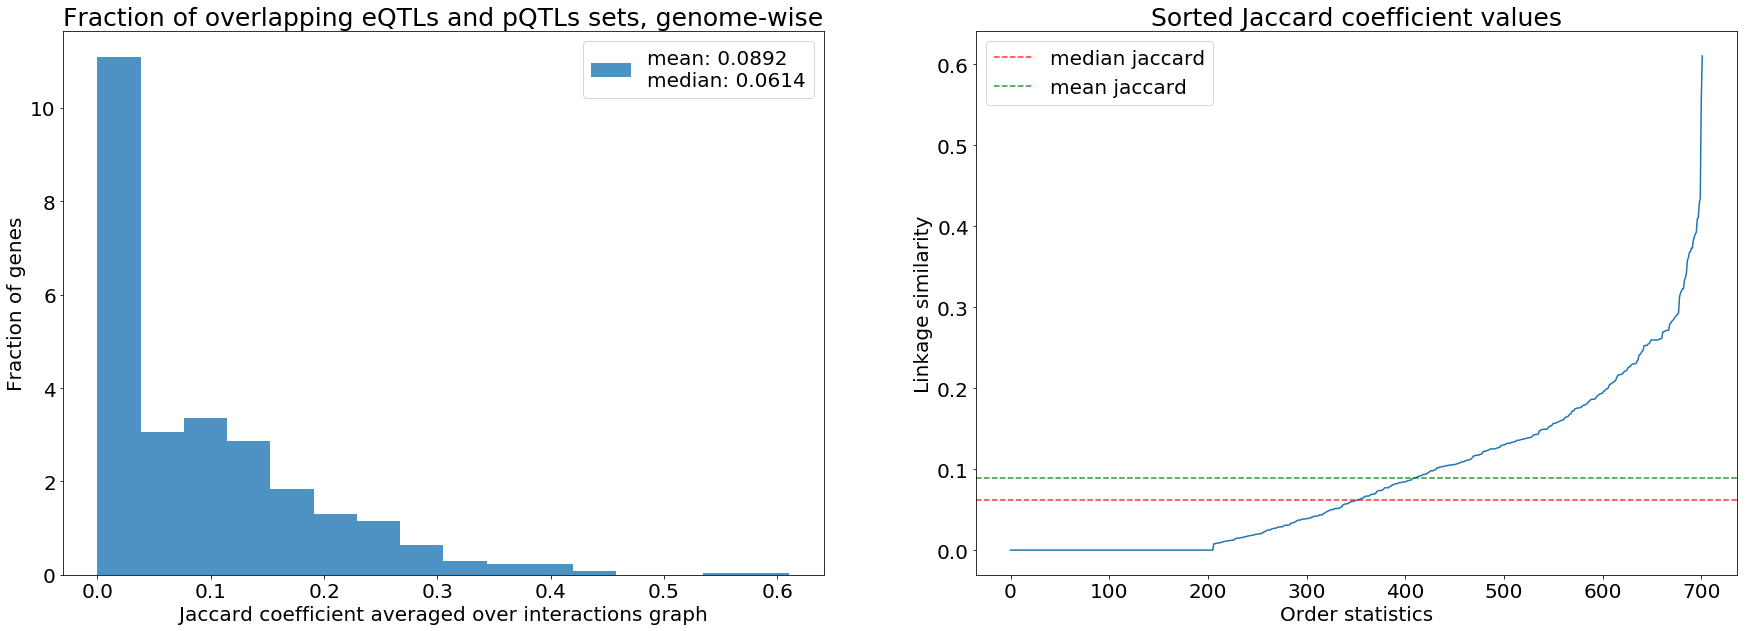

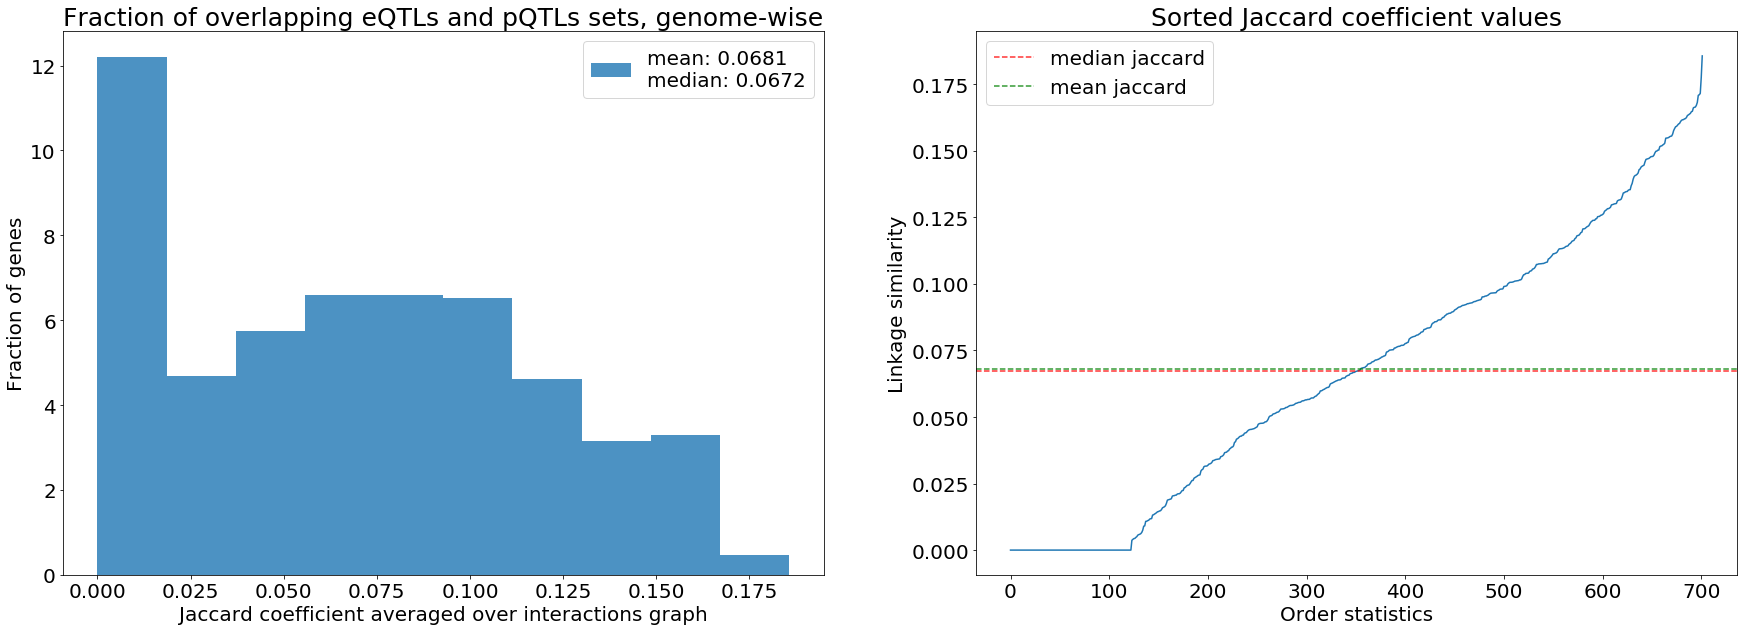

In [53]:
reload(qtls)

qtls.qtl_overlap_hist(geneontology_intersection_j, "geneontology")
qtls.qtl_overlap_hist(geneontology_randomized_intersection_j, "geneontology_randomized")

In [50]:
%%time

for simplify_flag in [False, True]:
     networks.basic_module_info(
         interactome_graph=interaction_graphs_dict["physical"], 
         modules_dict=geneontology_modules_dict, 
         modules_type="geneontology",
         simplify=simplify_flag).sort_values(by="genes count", ascending=False)\
         .to_csv("./results/geneontology/" 
              + ("simplified" if simplify_flag else "raw") 
              + "_module_stats.csv", sep='\t', index=False)

CPU times: user 3min 33s, sys: 376 ms, total: 3min 33s
Wall time: 3min 42s


In [20]:
geneontology_modules_df = pd.read_table("./results/geneontology/simplified_module_stats.csv").query("10 <= genes_with_interactions <= 150")
terms_to_test = set(geneontology_modules_df["module_name"])
geneontology_modules_dict = {go_term : genes for go_term, genes in geneontology_modules_dict.items() 
                             if go_term in terms_to_test}
print("{} modules in total".format(geneontology_modules_df.shape[0]))
display(geneontology_modules_df.sort_values(by="genes_with_interactions"))

694 modules in total


,module_name,genes_count,genes_with_interactions,interactions_count
1144,multimeric ribonuclease P complex,10,10,39
604,microtubule cytoskeleton organization involved...,19,10,8
961,regulation of translational initiation,12,10,11
596,ribonuclease activity,19,10,27
486,organonitrogen compound metabolic process,24,10,16
926,regulation of TORC1 signaling,12,10,16
914,ncRNA 3'-end processing,12,10,16
588,NADP metabolic process,20,10,5
446,response to abiotic stimulus,25,10,6
909,DNA polymerase complex,12,10,16


In [58]:
reload(qtls)

geneontology_modules_dict = qtls.process_ontologies(
    database_name="geneontology",
    expression_dfs=[eQTLs_expression_df, pQTLs_expression_df],
    qtl_dfs=[eQTLs_df, pQTLs_df],
    qtl_types=["eQTLs", "pQTLs"],
    interactome_graph=interaction_graphs_dict["physical"],
    module_gene=geneontology_modules_dict,
    q_thresholds=np.logspace(-5, -2, 10)
)

## Interacting genes tend to share linkages: analysis of functional modules from the Kegg database

In [36]:
# with open("./results/kegg_pathways/modules_dict.pkl", "wb+") as pickle_file:
#     pickle.dump(kegg_pathways_dict, pickle_file)
with open("./results/kegg_pathways/modules_dict.pkl", "rb+") as pickle_file:
    kegg_pathways_dict = pickle.load(pickle_file)

In [31]:
%%time 
kegg_pathways_dict = {("-".join(key.split('-')[:-1])):value for key, value in 
                     ontologies.query_KEGG(database="pathway", organism="sce").items()}

In [38]:
%%time 
# gene_pool = np.intersect1d(eQTLs_expression_df["gene"], pQTLs_expression_df["gene"])
gene_pool = np.unique(np.append(eQTLs_expression_df["gene"], pQTLs_expression_df["gene"]))

kegg_pathway_intersection_j, kegg_pathway_randomized_intersection_j = \
    qtls.qtl_overlap_test(eQTLs_df, pQTLs_df, gene_pool, kegg_pathways_dict)


random samples generated:   0%|          | 0/109 [00:00<?, ?it/s]

random samples generated:   1%|          | 1/109 [00:00<00:27,  3.96it/s]

random samples generated:   2%|▏         | 2/109 [00:00<00:32,  3.32it/s]

random samples generated:   3%|▎         | 3/109 [00:00<00:33,  3.18it/s]

random samples generated:   4%|▎         | 4/109 [00:01<00:31,  3.36it/s]

random samples generated:   5%|▍         | 5/109 [00:01<00:33,  3.14it/s]

random samples generated:   6%|▌         | 6/109 [00:01<00:30,  3.41it/s]

random samples generated:   6%|▋         | 7/109 [00:01<00:28,  3.53it/s]

random samples generated:   7%|▋         | 8/109 [00:02<00:29,  3.48it/s]

random samples generated:   8%|▊         | 9/109 [00:02<00:29,  3.44it/s]

random samples generated:   9%|▉         | 10/109 [00:02<00:28,  3.45it/s]

random samples generated:  10%|█         | 11/109 [00:03<00:28,  3.47it/s]

random samples generated:  11%|█         | 12/109 [00:03<00:27,  3.48it/s]

random samples generated:  12%|█▏        | 13/109 [00:03<00:26,  3.58it/s]

random samples generated:  13%|█▎        | 14/109 [00:03<00:26,  3.55it/s]

random samples generated:  14%|█▍        | 15/109 [00:04<00:26,  3.51it/s]

random samples generated:  15%|█▍        | 16/109 [00:04<00:27,  3.44it/s]

random samples generated:  16%|█▌        | 17/109 [00:04<00:26,  3.47it/s]

random samples generated:  17%|█▋        | 18/109 [00:05<00:25,  3.53it/s]

random samples generated:  17%|█▋        | 19/109 [00:05<00:25,  3.56it/s]

random samples generated:  18%|█▊        | 20/109 [00:05<00:24,  3.63it/s]

random samples generated:  19%|█▉        | 21/109 [00:05<00:24,  3.66it/s]

random samples generated:  20%|██        | 22/109 [00:05<00:23,  3.70it/s]

random samples generated:  21%|██        | 23/109 [00:06<00:23,  3.73it/s]

random samples generated:  22%|██▏       | 24/109 [00:06<00:22,  3.77it/s]

random samples generated:  23%|██▎       | 25/109 [00:06<00:22,  3.78it/s]

random samples generated:  24%|██▍       | 26/109 [00:06<00:21,  3.79it/s]

random samples generated:  25%|██▍       | 27/109 [00:07<00:21,  3.84it/s]

random samples generated:  26%|██▌       | 28/109 [00:07<00:20,  3.87it/s]

random samples generated:  27%|██▋       | 29/109 [00:07<00:20,  3.89it/s]

random samples generated:  28%|██▊       | 30/109 [00:07<00:20,  3.92it/s]

random samples generated:  28%|██▊       | 31/109 [00:07<00:19,  3.96it/s]

random samples generated:  29%|██▉       | 32/109 [00:08<00:19,  3.98it/s]

random samples generated:  30%|███       | 33/109 [00:08<00:19,  3.97it/s]

random samples generated:  31%|███       | 34/109 [00:08<00:18,  3.99it/s]

random samples generated:  32%|███▏      | 35/109 [00:08<00:18,  4.02it/s]

random samples generated:  33%|███▎      | 36/109 [00:08<00:18,  4.03it/s]

random samples generated:  34%|███▍      | 37/109 [00:09<00:17,  4.04it/s]

random samples generated:  35%|███▍      | 38/109 [00:09<00:17,  4.02it/s]

random samples generated:  36%|███▌      | 39/109 [00:09<00:17,  4.04it/s]

random samples generated:  37%|███▋      | 40/109 [00:09<00:16,  4.07it/s]

random samples generated:  38%|███▊      | 41/109 [00:10<00:16,  4.09it/s]

random samples generated:  39%|███▊      | 42/109 [00:10<00:16,  4.11it/s]

random samples generated:  39%|███▉      | 43/109 [00:10<00:16,  4.12it/s]

random samples generated:  40%|████      | 44/109 [00:10<00:15,  4.13it/s]

random samples generated:  41%|████▏     | 45/109 [00:10<00:15,  4.16it/s]

random samples generated:  42%|████▏     | 46/109 [00:11<00:15,  4.18it/s]

random samples generated:  43%|████▎     | 47/109 [00:11<00:14,  4.18it/s]

random samples generated:  44%|████▍     | 48/109 [00:11<00:14,  4.19it/s]

random samples generated:  45%|████▍     | 49/109 [00:11<00:14,  4.17it/s]

random samples generated:  46%|████▌     | 50/109 [00:12<00:14,  4.16it/s]

random samples generated:  47%|████▋     | 51/109 [00:12<00:13,  4.15it/s]

random samples generated:  48%|████▊     | 52/109 [00:12<00:13,  4.14it/s]

random samples generated:  49%|████▊     | 53/109 [00:12<00:13,  4.14it/s]

random samples generated:  50%|████▉     | 54/109 [00:12<00:13,  4.16it/s]

random samples generated:  50%|█████     | 55/109 [00:13<00:12,  4.16it/s]

random samples generated:  51%|█████▏    | 56/109 [00:13<00:12,  4.13it/s]

random samples generated:  52%|█████▏    | 57/109 [00:13<00:12,  4.14it/s]

random samples generated:  53%|█████▎    | 58/109 [00:13<00:12,  4.15it/s]

random samples generated:  54%|█████▍    | 59/109 [00:14<00:12,  4.15it/s]

random samples generated:  55%|█████▌    | 60/109 [00:14<00:11,  4.15it/s]

random samples generated:  56%|█████▌    | 61/109 [00:14<00:11,  4.16it/s]

random samples generated:  57%|█████▋    | 62/109 [00:14<00:11,  4.17it/s]

random samples generated:  58%|█████▊    | 63/109 [00:15<00:11,  4.18it/s]

random samples generated:  59%|█████▊    | 64/109 [00:15<00:10,  4.19it/s]

random samples generated:  60%|█████▉    | 65/109 [00:15<00:10,  4.21it/s]

random samples generated:  61%|██████    | 66/109 [00:15<00:10,  4.21it/s]

random samples generated:  61%|██████▏   | 67/109 [00:15<00:10,  4.20it/s]

random samples generated:  62%|██████▏   | 68/109 [00:16<00:09,  4.19it/s]

random samples generated:  63%|██████▎   | 69/109 [00:16<00:09,  4.20it/s]

random samples generated:  64%|██████▍   | 70/109 [00:16<00:09,  4.22it/s]

random samples generated:  65%|██████▌   | 71/109 [00:16<00:09,  4.22it/s]

random samples generated:  66%|██████▌   | 72/109 [00:17<00:08,  4.22it/s]

random samples generated:  67%|██████▋   | 73/109 [00:17<00:08,  4.22it/s]

random samples generated:  68%|██████▊   | 74/109 [00:17<00:08,  4.23it/s]

random samples generated:  69%|██████▉   | 75/109 [00:17<00:08,  4.24it/s]

random samples generated:  70%|██████▉   | 76/109 [00:17<00:07,  4.24it/s]

random samples generated:  71%|███████   | 77/109 [00:18<00:07,  4.21it/s]

random samples generated:  72%|███████▏  | 78/109 [00:18<00:07,  4.24it/s]

random samples generated:  72%|███████▏  | 79/109 [00:18<00:07,  4.24it/s]

random samples generated:  73%|███████▎  | 80/109 [00:18<00:06,  4.25it/s]

random samples generated:  74%|███████▍  | 81/109 [00:19<00:06,  4.25it/s]

random samples generated:  75%|███████▌  | 82/109 [00:19<00:06,  4.26it/s]

random samples generated:  76%|███████▌  | 83/109 [00:19<00:06,  4.25it/s]

random samples generated:  77%|███████▋  | 84/109 [00:19<00:05,  4.25it/s]

random samples generated:  78%|███████▊  | 85/109 [00:19<00:05,  4.26it/s]

random samples generated:  79%|███████▉  | 86/109 [00:20<00:05,  4.27it/s]

random samples generated:  80%|███████▉  | 87/109 [00:20<00:05,  4.28it/s]

random samples generated:  81%|████████  | 88/109 [00:20<00:04,  4.27it/s]

random samples generated:  82%|████████▏ | 89/109 [00:20<00:04,  4.26it/s]

random samples generated:  83%|████████▎ | 90/109 [00:21<00:04,  4.26it/s]

random samples generated:  83%|████████▎ | 91/109 [00:21<00:04,  4.26it/s]

random samples generated:  84%|████████▍ | 92/109 [00:21<00:03,  4.26it/s]

random samples generated:  85%|████████▌ | 93/109 [00:21<00:03,  4.26it/s]

random samples generated:  86%|████████▌ | 94/109 [00:22<00:03,  4.27it/s]

random samples generated:  87%|████████▋ | 95/109 [00:22<00:03,  4.28it/s]

random samples generated:  88%|████████▊ | 96/109 [00:22<00:03,  4.26it/s]

random samples generated:  89%|████████▉ | 97/109 [00:22<00:02,  4.25it/s]

random samples generated:  90%|████████▉ | 98/109 [00:23<00:02,  4.26it/s]

random samples generated:  91%|█████████ | 99/109 [00:23<00:02,  4.26it/s]

random samples generated:  92%|█████████▏| 100/109 [00:23<00:02,  4.24it/s]

random samples generated:  93%|█████████▎| 101/109 [00:23<00:01,  4.24it/s]

random samples generated:  94%|█████████▎| 102/109 [00:24<00:01,  4.24it/s]

random samples generated:  94%|█████████▍| 103/109 [00:24<00:01,  4.24it/s]

random samples generated:  95%|█████████▌| 104/109 [00:24<00:01,  4.24it/s]

random samples generated:  96%|█████████▋| 105/109 [00:24<00:00,  4.25it/s]

random samples generated:  97%|█████████▋| 106/109 [00:24<00:00,  4.25it/s]

random samples generated:  98%|█████████▊| 107/109 [00:25<00:00,  4.26it/s]

random samples generated:  99%|█████████▉| 108/109 [00:25<00:00,  4.27it/s]

random samples generated: 100%|██████████| 109/109 [00:25<00:00,  4.27it/s]

CPU times: user 25.9 s, sys: 104 ms, total: 26 s
Wall time: 25.8 s


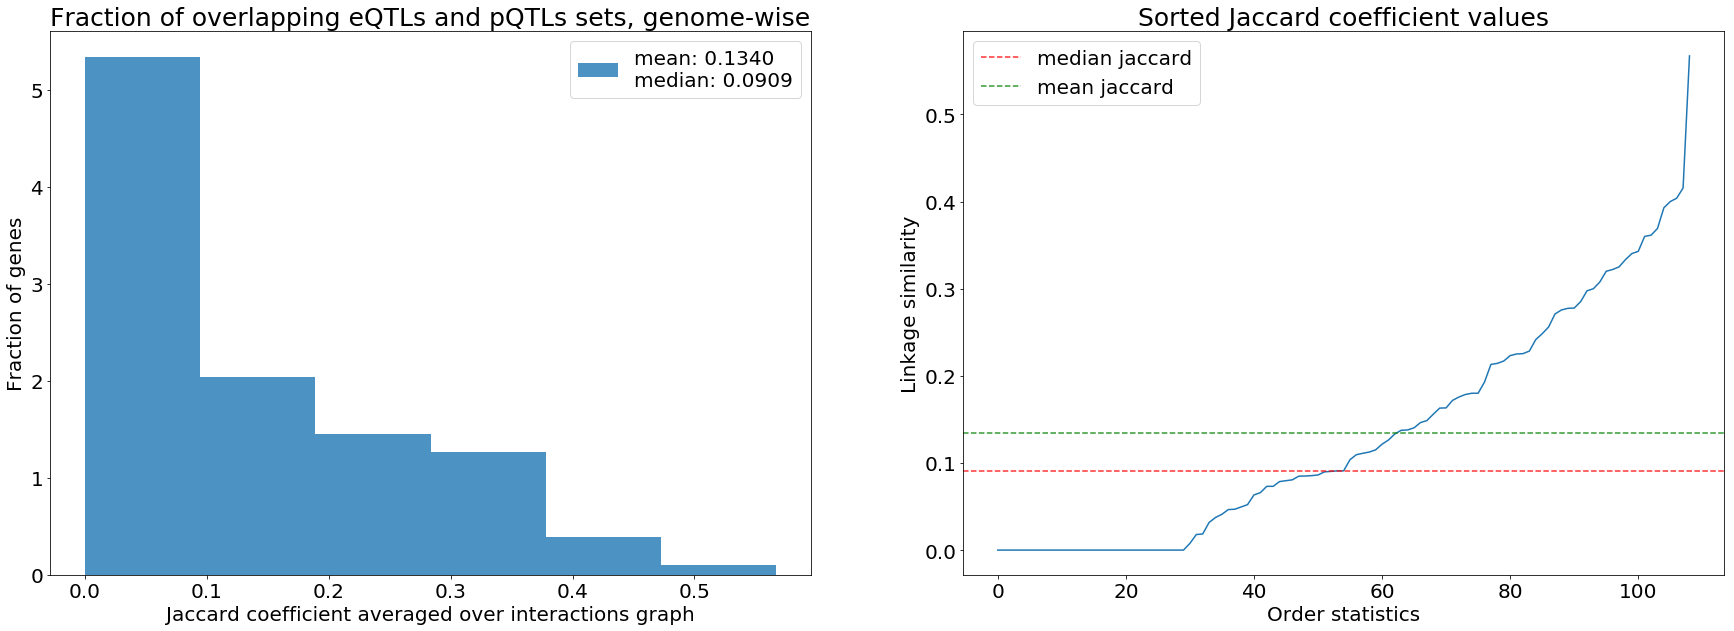

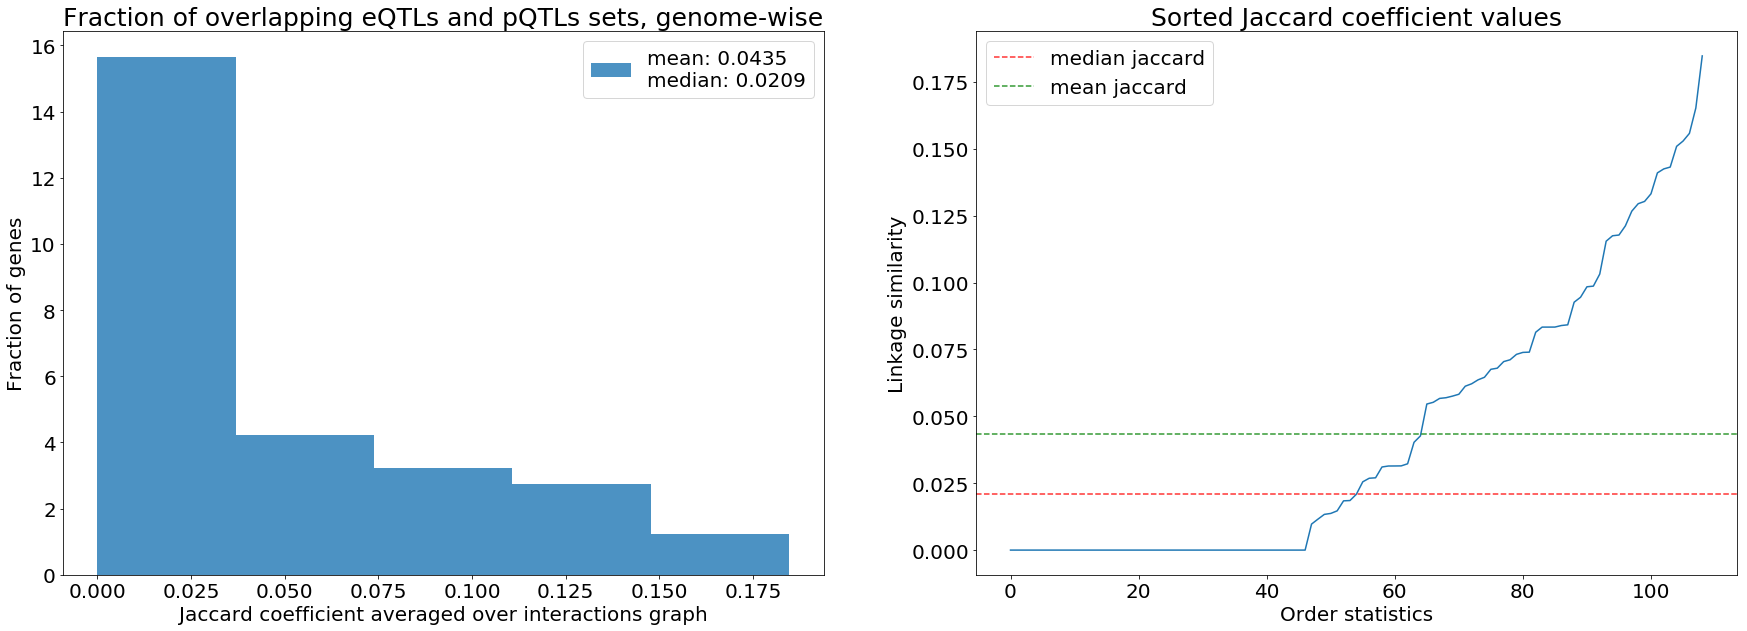

In [59]:
qtls.qtl_overlap_hist(kegg_pathway_intersection_j, "kegg_pathways")
qtls.qtl_overlap_hist(kegg_pathway_randomized_intersection_j, "kegg_pathways_randomized")

In [108]:
%%time

for simplify_flag in [False, True]:
     display(networks.basic_module_info(
         interactome_graph=interaction_graphs_dict["all"], 
         modules_dict=kegg_pathways_dict, 
         modules_type="kegg_pathways",
         simplify=simplify_flag).sort_values(by="genes count", ascending=False))

cairo.IOError: error while writing to output stream

In [78]:
reload(qtls)
results = qtls.process_ontologies(
    database_name="kegg_pathways",
    expression_dfs=[eQTLs_expression_df],#[eQTLs_expression_df, pQTLs_expression_df],
    qtl_dfs=[eQTLs_df],#[eQTLs_df, pQTLs_df],
    qtl_types=["eQTLs"],#["eQTLs", "pQTLs"],
    interactome_graph=interaction_graphs_dict["physical"],
    module_gene=kegg_pathways_dict,
    q_thresholds=np.logspace(-5, -2, 10),
    pairwise_test_iter=200,
    ppi_test_iter=64
)
display(results)

# eQTL_graph = networks.graph_from_edges(eQTLs_df[eQTLs_df["q.value"] <= 0.01][["SNP", "gene"]].values)
# np.isclose(qtls.linkage_similarity(
#     module_graph=interaction_graphs_dict["physical"].subgraph(
#         np.intersect1d(interaction_graphs_dict["physical"].vs["name"],
#                        kegg_pathways_dict["Butanoate metabolism "])
#     ),
#     qtl_graph=eQTL_graph
# ), 0)

[('ABC transporters ', 'no linkages'), ('AGE-RAGE signaling pathway in diabetic complications ', 'less than 4 vertices'), ('Amino sugar and nucleotide sugar metabolism ', "linkage sets don't intersect"), ('Aminoacyl-tRNA biosynthesis ', "linkage sets don't intersect"), ('Arachidonic acid metabolism ', 'less than 4 vertices'), ('Arginine and proline metabolism ', 'less than 4 vertices'), ('Atrazine degradation ', 'less than 4 vertices'), ('Autophagy - other ', "linkage sets don't intersect"), ('Autophagy - yeast ', "linkage sets don't intersect"), ('Basal transcription factors ', "linkage sets don't intersect"), ('Base excision repair ', "linkage sets don't intersect"), ('Biosynthesis of unsaturated fatty acids ', 'no linkages'), ('Biotin metabolism ', 'less than 4 vertices'), ('Butanoate metabolism ', "linkage sets don't intersect"), ('C5-Branched dibasic acid metabolism ', 'less than 4 vertices'), ('Carbapenem biosynthesis ', 'less than 4 vertices'), ('Citrate cycle (TCA cycle) ', "li

defaultdict(None,
            {'Alanine, aspartate and glutamate metabolism ': ['GFA1',
              'ASP3-1',
              'ASN2',
              'ARG4',
              'GLT1',
              'ADE12',
              'ASP3-3',
              'CPA1',
              'ARG1',
              'UGA1',
              'ASP3-2',
              'AGX1',
              'GDH3',
              'ALT2',
              'AAT1',
              'CPA2',
              'YMR084W',
              'ASN1',
              'URA2',
              'PUT2',
              'ASP1',
              'UGA2',
              'GDH2',
              'ALT1',
              'GDH1',
              'ADE4',
              'GAD1',
              'AAT2',
              'ASP3-4',
              'ADE13',
              'NIT3',
              'GLN1'],
             'Arginine biosynthesis ': ['GDH2',
              'ARG5,6',
              'ARG1',
              'ARG3',
              'ALT1',
              'GDH1',
              'ARG8',
              'AAT2',
            

In [75]:
# with open("./results/kegg_modules/modules_dict.pkl", "wb+") as pickle_file:
#     pickle.dump(kegg_modules_dict, pickle_file)
with open("./results/kegg_modules/modules_dict.pkl", "rb+") as pickle_file:
    kegg_modules_dict = pickle.load(pickle_file)

FileNotFoundError: [Errno 2] No such file or directory: './results/kegg_modules/modules_dict.pkl'

In [49]:
%%time
reload(ontologies)

kegg_modules_dict = {key.replace('=>', 'to'):value for key, value in 
                     ontologies.query_KEGG(database="module", organism="sce").items()}
ontologies.query_KEGG(database="module", organism="sce").items()

modules retrieved:   0%|          | 0/108 [00:00<?, ?it/s]

modules retrieved:   1%|          | 1/108 [00:01<01:53,  1.07s/it]

modules retrieved:   2%|▏         | 2/108 [00:01<01:33,  1.13it/s]

modules retrieved:   3%|▎         | 3/108 [00:02<01:26,  1.21it/s]

modules retrieved:   4%|▎         | 4/108 [00:03<01:21,  1.27it/s]

modules retrieved:   5%|▍         | 5/108 [00:03<01:19,  1.30it/s]

modules retrieved:   6%|▌         | 6/108 [00:04<01:17,  1.31it/s]

modules retrieved:   6%|▋         | 7/108 [00:05<01:16,  1.32it/s]

modules retrieved:   7%|▋         | 8/108 [00:06<01:20,  1.25it/s]

modules retrieved:   8%|▊         | 9/108 [00:07<01:18,  1.26it/s]

modules retrieved:   9%|▉         | 10/108 [00:07<01:17,  1.27it/s]

modules retrieved:  10%|█         | 11/108 [00:08<01:15,  1.28it/s]

modules retrieved:  11%|█         | 12/108 [00:09<01:14,  1.29it/s]

modules retrieved:  12%|█▏        | 13/108 [00:09<01:12,  1.30it/s]

modules retrieved:  13%|█▎        | 14/108 [00:10<01:12,  1.31it/s]

modules retrieved:  14%|█▍        | 15/108 [00:11<01:10,  1.31it/s]

modules retrieved:  15%|█▍        | 16/108 [00:12<01:09,  1.32it/s]

modules retrieved:  16%|█▌        | 17/108 [00:12<01:08,  1.32it/s]

modules retrieved:  17%|█▋        | 18/108 [00:13<01:07,  1.33it/s]

modules retrieved:  18%|█▊        | 19/108 [00:14<01:07,  1.33it/s]

modules retrieved:  19%|█▊        | 20/108 [00:15<01:06,  1.33it/s]

modules retrieved:  19%|█▉        | 21/108 [00:15<01:05,  1.34it/s]

modules retrieved:  20%|██        | 22/108 [00:16<01:04,  1.34it/s]

modules retrieved:  21%|██▏       | 23/108 [00:17<01:03,  1.34it/s]

modules retrieved:  22%|██▏       | 24/108 [00:17<01:02,  1.34it/s]

modules retrieved:  23%|██▎       | 25/108 [00:18<01:01,  1.34it/s]

modules retrieved:  24%|██▍       | 26/108 [00:19<01:00,  1.34it/s]

modules retrieved:  25%|██▌       | 27/108 [00:20<01:00,  1.35it/s]

modules retrieved:  26%|██▌       | 28/108 [00:20<00:59,  1.35it/s]

modules retrieved:  27%|██▋       | 29/108 [00:21<00:58,  1.35it/s]

modules retrieved:  28%|██▊       | 30/108 [00:22<00:57,  1.35it/s]

modules retrieved:  29%|██▊       | 31/108 [00:22<00:56,  1.35it/s]

modules retrieved:  30%|██▉       | 32/108 [00:23<00:56,  1.35it/s]

modules retrieved:  31%|███       | 33/108 [00:24<00:55,  1.36it/s]

modules retrieved:  31%|███▏      | 34/108 [00:25<00:54,  1.36it/s]

modules retrieved:  32%|███▏      | 35/108 [00:25<00:53,  1.36it/s]

modules retrieved:  33%|███▎      | 36/108 [00:26<00:52,  1.36it/s]

modules retrieved:  34%|███▍      | 37/108 [00:27<00:52,  1.36it/s]

modules retrieved:  35%|███▌      | 38/108 [00:27<00:51,  1.36it/s]

modules retrieved:  36%|███▌      | 39/108 [00:28<00:50,  1.36it/s]

modules retrieved:  37%|███▋      | 40/108 [00:29<00:49,  1.36it/s]

modules retrieved:  38%|███▊      | 41/108 [00:30<00:49,  1.36it/s]

modules retrieved:  39%|███▉      | 42/108 [00:30<00:48,  1.36it/s]

modules retrieved:  40%|███▉      | 43/108 [00:31<00:47,  1.37it/s]

modules retrieved:  41%|████      | 44/108 [00:32<00:46,  1.36it/s]

modules retrieved:  42%|████▏     | 45/108 [00:32<00:46,  1.37it/s]

modules retrieved:  43%|████▎     | 46/108 [00:33<00:45,  1.37it/s]

modules retrieved:  44%|████▎     | 47/108 [00:34<00:44,  1.37it/s]

modules retrieved:  44%|████▍     | 48/108 [00:35<00:43,  1.37it/s]

modules retrieved:  45%|████▌     | 49/108 [00:35<00:43,  1.37it/s]

modules retrieved:  46%|████▋     | 50/108 [00:36<00:42,  1.37it/s]

modules retrieved:  47%|████▋     | 51/108 [00:37<00:41,  1.37it/s]

modules retrieved:  48%|████▊     | 52/108 [00:37<00:40,  1.37it/s]

modules retrieved:  49%|████▉     | 53/108 [00:38<00:40,  1.37it/s]

modules retrieved:  50%|█████     | 54/108 [00:39<00:39,  1.37it/s]

modules retrieved:  51%|█████     | 55/108 [00:40<00:39,  1.35it/s]

modules retrieved:  52%|█████▏    | 56/108 [00:41<00:38,  1.34it/s]

modules retrieved:  53%|█████▎    | 57/108 [00:42<00:37,  1.34it/s]

modules retrieved:  54%|█████▎    | 58/108 [00:43<00:37,  1.35it/s]

modules retrieved:  55%|█████▍    | 59/108 [00:43<00:36,  1.35it/s]

modules retrieved:  56%|█████▌    | 60/108 [00:44<00:35,  1.35it/s]

modules retrieved:  56%|█████▋    | 61/108 [00:45<00:34,  1.35it/s]

modules retrieved:  57%|█████▋    | 62/108 [00:45<00:34,  1.35it/s]

modules retrieved:  58%|█████▊    | 63/108 [00:46<00:33,  1.35it/s]

modules retrieved:  59%|█████▉    | 64/108 [00:47<00:32,  1.35it/s]

modules retrieved:  60%|██████    | 65/108 [00:48<00:31,  1.35it/s]

modules retrieved:  61%|██████    | 66/108 [00:48<00:31,  1.35it/s]

modules retrieved:  62%|██████▏   | 67/108 [00:49<00:30,  1.35it/s]

modules retrieved:  63%|██████▎   | 68/108 [00:50<00:29,  1.35it/s]

modules retrieved:  64%|██████▍   | 69/108 [00:50<00:28,  1.36it/s]

modules retrieved:  65%|██████▍   | 70/108 [00:51<00:28,  1.36it/s]

modules retrieved:  66%|██████▌   | 71/108 [00:52<00:27,  1.35it/s]

modules retrieved:  67%|██████▋   | 72/108 [00:53<00:26,  1.35it/s]

modules retrieved:  68%|██████▊   | 73/108 [00:54<00:26,  1.34it/s]

modules retrieved:  69%|██████▊   | 74/108 [00:55<00:25,  1.33it/s]

modules retrieved:  69%|██████▉   | 75/108 [00:56<00:24,  1.33it/s]

modules retrieved:  70%|███████   | 76/108 [00:57<00:24,  1.33it/s]

modules retrieved:  71%|███████▏  | 77/108 [00:57<00:23,  1.33it/s]

modules retrieved:  72%|███████▏  | 78/108 [00:58<00:22,  1.33it/s]

modules retrieved:  73%|███████▎  | 79/108 [00:59<00:21,  1.33it/s]

modules retrieved:  74%|███████▍  | 80/108 [01:00<00:21,  1.33it/s]

modules retrieved:  75%|███████▌  | 81/108 [01:00<00:20,  1.33it/s]

modules retrieved:  76%|███████▌  | 82/108 [01:01<00:19,  1.33it/s]

modules retrieved:  77%|███████▋  | 83/108 [01:02<00:18,  1.33it/s]

modules retrieved:  78%|███████▊  | 84/108 [01:02<00:17,  1.33it/s]

modules retrieved:  79%|███████▊  | 85/108 [01:03<00:17,  1.34it/s]

modules retrieved:  80%|███████▉  | 86/108 [01:04<00:16,  1.34it/s]

modules retrieved:  81%|████████  | 87/108 [01:05<00:15,  1.34it/s]

modules retrieved:  81%|████████▏ | 88/108 [01:05<00:14,  1.34it/s]

modules retrieved:  82%|████████▏ | 89/108 [01:06<00:14,  1.34it/s]

modules retrieved:  83%|████████▎ | 90/108 [01:07<00:13,  1.34it/s]

modules retrieved:  84%|████████▍ | 91/108 [01:07<00:12,  1.34it/s]

modules retrieved:  85%|████████▌ | 92/108 [01:08<00:11,  1.34it/s]

modules retrieved:  86%|████████▌ | 93/108 [01:09<00:11,  1.34it/s]

modules retrieved:  87%|████████▋ | 94/108 [01:10<00:10,  1.34it/s]

modules retrieved:  88%|████████▊ | 95/108 [01:10<00:09,  1.34it/s]

modules retrieved:  89%|████████▉ | 96/108 [01:11<00:08,  1.34it/s]

modules retrieved:  90%|████████▉ | 97/108 [01:12<00:08,  1.34it/s]

modules retrieved:  91%|█████████ | 98/108 [01:12<00:07,  1.34it/s]

modules retrieved:  92%|█████████▏| 99/108 [01:13<00:06,  1.34it/s]

modules retrieved:  93%|█████████▎| 100/108 [01:14<00:05,  1.34it/s]

modules retrieved:  94%|█████████▎| 101/108 [01:15<00:05,  1.34it/s]

modules retrieved:  94%|█████████▍| 102/108 [01:15<00:04,  1.34it/s]

modules retrieved:  95%|█████████▌| 103/108 [01:16<00:03,  1.35it/s]

modules retrieved:  96%|█████████▋| 104/108 [01:17<00:02,  1.35it/s]

modules retrieved:  97%|█████████▋| 105/108 [01:18<00:02,  1.35it/s]

modules retrieved:  98%|█████████▊| 106/108 [01:18<00:01,  1.35it/s]

modules retrieved:  99%|█████████▉| 107/108 [01:19<00:00,  1.35it/s]

modules retrieved: 100%|██████████| 108/108 [01:20<00:00,  1.35it/s]

modules retrieved:   0%|          | 0/108 [00:00<?, ?it/s]

modules retrieved:   1%|          | 1/108 [00:01<01:53,  1.06s/it]

modules retrieved:   2%|▏         | 2/108 [00:01<01:33,  1.14it/s]

modules retrieved:   3%|▎         | 3/108 [00:02<01:26,  1.21it/s]

modules retrieved:   4%|▎         | 4/108 [00:03<01:23,  1.25it/s]

modules retrieved:   5%|▍         | 5/108 [00:03<01:19,  1.29it/s]

modules retrieved:   6%|▌         | 6/108 [00:04<01:17,  1.31it/s]

modules retrieved:   6%|▋         | 7/108 [00:05<01:16,  1.32it/s]

modules retrieved:   7%|▋         | 8/108 [00:06<01:19,  1.25it/s]

modules retrieved:   8%|▊         | 9/108 [00:07<01:21,  1.22it/s]

modules retrieved:   9%|▉         | 10/108 [00:08<01:19,  1.24it/s]

modules retrieved:  10%|█         | 11/108 [00:08<01:17,  1.25it/s]

modules retrieved:  11%|█         | 12/108 [00:09<01:15,  1.26it/s]

modules retrieved:  12%|█▏        | 13/108 [00:10<01:14,  1.27it/s]

modules retrieved:  13%|█▎        | 14/108 [00:10<01:13,  1.28it/s]

modules retrieved:  14%|█▍        | 15/108 [00:11<01:12,  1.29it/s]

modules retrieved:  15%|█▍        | 16/108 [00:12<01:10,  1.30it/s]

modules retrieved:  16%|█▌        | 17/108 [00:13<01:09,  1.30it/s]

modules retrieved:  17%|█▋        | 18/108 [00:14<01:14,  1.20it/s]

modules retrieved:  18%|█▊        | 19/108 [00:15<01:13,  1.21it/s]

modules retrieved:  19%|█▊        | 20/108 [00:16<01:12,  1.22it/s]

modules retrieved:  19%|█▉        | 21/108 [00:17<01:10,  1.23it/s]

modules retrieved:  20%|██        | 22/108 [00:17<01:09,  1.24it/s]

modules retrieved:  21%|██▏       | 23/108 [00:18<01:08,  1.24it/s]

modules retrieved:  22%|██▏       | 24/108 [00:19<01:07,  1.25it/s]

modules retrieved:  23%|██▎       | 25/108 [00:19<01:06,  1.25it/s]

modules retrieved:  24%|██▍       | 26/108 [00:20<01:05,  1.26it/s]

modules retrieved:  25%|██▌       | 27/108 [00:21<01:04,  1.26it/s]

modules retrieved:  26%|██▌       | 28/108 [00:22<01:03,  1.27it/s]

modules retrieved:  27%|██▋       | 29/108 [00:23<01:04,  1.22it/s]

modules retrieved:  28%|██▊       | 30/108 [00:24<01:03,  1.23it/s]

modules retrieved:  29%|██▊       | 31/108 [00:25<01:02,  1.23it/s]

modules retrieved:  30%|██▉       | 32/108 [00:25<01:01,  1.24it/s]

modules retrieved:  31%|███       | 33/108 [00:26<01:00,  1.24it/s]

modules retrieved:  31%|███▏      | 34/108 [00:27<00:59,  1.25it/s]

modules retrieved:  32%|███▏      | 35/108 [00:27<00:58,  1.25it/s]

modules retrieved:  33%|███▎      | 36/108 [00:28<00:57,  1.26it/s]

modules retrieved:  34%|███▍      | 37/108 [00:29<00:56,  1.26it/s]

modules retrieved:  35%|███▌      | 38/108 [00:30<00:55,  1.26it/s]

modules retrieved:  36%|███▌      | 39/108 [00:30<00:54,  1.27it/s]

modules retrieved:  37%|███▋      | 40/108 [00:31<00:53,  1.26it/s]

modules retrieved:  38%|███▊      | 41/108 [00:32<00:52,  1.26it/s]

modules retrieved:  39%|███▉      | 42/108 [00:33<00:52,  1.27it/s]

modules retrieved:  40%|███▉      | 43/108 [00:33<00:51,  1.27it/s]

modules retrieved:  41%|████      | 44/108 [00:34<00:50,  1.27it/s]

modules retrieved:  42%|████▏     | 45/108 [00:35<00:49,  1.28it/s]

modules retrieved:  43%|████▎     | 46/108 [00:36<00:48,  1.28it/s]

modules retrieved:  44%|████▎     | 47/108 [00:36<00:47,  1.28it/s]

modules retrieved:  44%|████▍     | 48/108 [00:37<00:46,  1.28it/s]

modules retrieved:  45%|████▌     | 49/108 [00:38<00:45,  1.28it/s]

modules retrieved:  46%|████▋     | 50/108 [00:38<00:45,  1.29it/s]

modules retrieved:  47%|████▋     | 51/108 [00:39<00:44,  1.29it/s]

modules retrieved:  48%|████▊     | 52/108 [00:40<00:43,  1.29it/s]

modules retrieved:  49%|████▉     | 53/108 [00:41<00:42,  1.29it/s]

modules retrieved:  50%|█████     | 54/108 [00:41<00:41,  1.29it/s]

modules retrieved:  51%|█████     | 55/108 [00:43<00:41,  1.27it/s]

modules retrieved:  52%|█████▏    | 56/108 [00:44<00:40,  1.27it/s]

modules retrieved:  53%|█████▎    | 57/108 [00:44<00:40,  1.27it/s]

modules retrieved:  54%|█████▎    | 58/108 [00:45<00:39,  1.27it/s]

modules retrieved:  55%|█████▍    | 59/108 [00:46<00:38,  1.28it/s]

modules retrieved:  56%|█████▌    | 60/108 [00:46<00:37,  1.28it/s]

modules retrieved:  56%|█████▋    | 61/108 [00:47<00:36,  1.28it/s]

modules retrieved:  57%|█████▋    | 62/108 [00:48<00:35,  1.28it/s]

modules retrieved:  58%|█████▊    | 63/108 [00:49<00:35,  1.28it/s]

modules retrieved:  59%|█████▉    | 64/108 [00:49<00:34,  1.28it/s]

modules retrieved:  60%|██████    | 65/108 [00:50<00:33,  1.29it/s]

modules retrieved:  61%|██████    | 66/108 [00:51<00:32,  1.29it/s]

modules retrieved:  62%|██████▏   | 67/108 [00:51<00:31,  1.29it/s]

modules retrieved:  63%|██████▎   | 68/108 [00:52<00:31,  1.29it/s]

modules retrieved:  64%|██████▍   | 69/108 [00:53<00:30,  1.29it/s]

modules retrieved:  65%|██████▍   | 70/108 [00:54<00:29,  1.29it/s]

modules retrieved:  66%|██████▌   | 71/108 [00:54<00:28,  1.29it/s]

modules retrieved:  67%|██████▋   | 72/108 [00:55<00:27,  1.29it/s]

modules retrieved:  68%|██████▊   | 73/108 [00:56<00:27,  1.29it/s]

modules retrieved:  69%|██████▊   | 74/108 [00:57<00:26,  1.29it/s]

modules retrieved:  69%|██████▉   | 75/108 [00:58<00:25,  1.29it/s]

modules retrieved:  70%|███████   | 76/108 [00:58<00:24,  1.29it/s]

modules retrieved:  71%|███████▏  | 77/108 [00:59<00:23,  1.29it/s]

modules retrieved:  72%|███████▏  | 78/108 [01:00<00:23,  1.29it/s]

modules retrieved:  73%|███████▎  | 79/108 [01:00<00:22,  1.30it/s]

modules retrieved:  74%|███████▍  | 80/108 [01:01<00:21,  1.30it/s]

modules retrieved:  75%|███████▌  | 81/108 [01:02<00:20,  1.30it/s]

modules retrieved:  76%|███████▌  | 82/108 [01:03<00:20,  1.30it/s]

modules retrieved:  77%|███████▋  | 83/108 [01:03<00:19,  1.30it/s]

modules retrieved:  78%|███████▊  | 84/108 [01:04<00:18,  1.30it/s]

modules retrieved:  79%|███████▊  | 85/108 [01:05<00:17,  1.30it/s]

modules retrieved:  80%|███████▉  | 86/108 [01:06<00:16,  1.30it/s]

modules retrieved:  81%|████████  | 87/108 [01:06<00:16,  1.30it/s]

modules retrieved:  81%|████████▏ | 88/108 [01:07<00:15,  1.30it/s]

modules retrieved:  82%|████████▏ | 89/108 [01:08<00:14,  1.31it/s]

modules retrieved:  83%|████████▎ | 90/108 [01:08<00:13,  1.31it/s]

modules retrieved:  84%|████████▍ | 91/108 [01:09<00:13,  1.31it/s]

modules retrieved:  85%|████████▌ | 92/108 [01:10<00:12,  1.31it/s]

modules retrieved:  86%|████████▌ | 93/108 [01:11<00:11,  1.31it/s]

modules retrieved:  87%|████████▋ | 94/108 [01:11<00:10,  1.31it/s]

modules retrieved:  88%|████████▊ | 95/108 [01:12<00:09,  1.31it/s]

modules retrieved:  89%|████████▉ | 96/108 [01:13<00:09,  1.31it/s]

modules retrieved:  90%|████████▉ | 97/108 [01:13<00:08,  1.31it/s]

modules retrieved:  91%|█████████ | 98/108 [01:14<00:07,  1.31it/s]

modules retrieved:  92%|█████████▏| 99/108 [01:15<00:06,  1.31it/s]

modules retrieved:  93%|█████████▎| 100/108 [01:16<00:06,  1.31it/s]

modules retrieved:  94%|█████████▎| 101/108 [01:16<00:05,  1.32it/s]

modules retrieved:  94%|█████████▍| 102/108 [01:17<00:04,  1.32it/s]

modules retrieved:  95%|█████████▌| 103/108 [01:18<00:03,  1.32it/s]

modules retrieved:  96%|█████████▋| 104/108 [01:18<00:03,  1.32it/s]

modules retrieved:  97%|█████████▋| 105/108 [01:19<00:02,  1.32it/s]

modules retrieved:  98%|█████████▊| 106/108 [01:20<00:01,  1.32it/s]

modules retrieved:  99%|█████████▉| 107/108 [01:21<00:00,  1.32it/s]

modules retrieved: 100%|██████████| 108/108 [01:21<00:00,  1.32it/s]

CPU times: user 5.3 s, sys: 304 ms, total: 5.61 s
Wall time: 2min 47s


In [50]:
%%time 

reload(qtls)

# gene_pool = np.intersect1d(eQTLs_expression_df["gene"], pQTLs_expression_df["gene"])
gene_pool = np.union1d(eQTLs_expression_df["gene"], pQTLs_expression_df["gene"])

kegg_module_intersection_j, kegg_module_randomized_intersection_j = \
    qtls.qtl_overlap_test(eQTLs_df, pQTLs_df, gene_pool, kegg_modules_dict)

random samples generated:   0%|          | 0/108 [00:00<?, ?it/s]

random samples generated:   1%|          | 1/108 [00:00<00:21,  4.88it/s]

random samples generated:   2%|▏         | 2/108 [00:00<00:21,  5.02it/s]

random samples generated:   3%|▎         | 3/108 [00:00<00:19,  5.25it/s]

random samples generated:   4%|▎         | 4/108 [00:00<00:19,  5.40it/s]

random samples generated:   5%|▍         | 5/108 [00:00<00:19,  5.35it/s]

random samples generated:   6%|▌         | 6/108 [00:01<00:19,  5.27it/s]

random samples generated:   6%|▋         | 7/108 [00:01<00:18,  5.34it/s]

random samples generated:   7%|▋         | 8/108 [00:01<00:18,  5.29it/s]

random samples generated:   8%|▊         | 9/108 [00:01<00:19,  5.14it/s]

random samples generated:   9%|▉         | 10/108 [00:01<00:19,  5.05it/s]

random samples generated:  10%|█         | 11/108 [00:02<00:19,  5.03it/s]

random samples generated:  11%|█         | 12/108 [00:02<00:18,  5.07it/s]

random samples generated:  12%|█▏        | 13/108 [00:02<00:19,  4.97it/s]

random samples generated:  13%|█▎        | 14/108 [00:02<00:18,  5.02it/s]

random samples generated:  14%|█▍        | 15/108 [00:02<00:18,  5.06it/s]

random samples generated:  15%|█▍        | 16/108 [00:03<00:18,  5.04it/s]

random samples generated:  16%|█▌        | 17/108 [00:03<00:17,  5.07it/s]

random samples generated:  17%|█▋        | 18/108 [00:03<00:17,  5.05it/s]

random samples generated:  18%|█▊        | 19/108 [00:03<00:17,  5.04it/s]

random samples generated:  19%|█▊        | 20/108 [00:03<00:17,  5.03it/s]

random samples generated:  19%|█▉        | 21/108 [00:04<00:17,  5.02it/s]

random samples generated:  20%|██        | 22/108 [00:04<00:17,  4.97it/s]

random samples generated:  21%|██▏       | 23/108 [00:04<00:17,  4.95it/s]

random samples generated:  22%|██▏       | 24/108 [00:04<00:17,  4.84it/s]

random samples generated:  23%|██▎       | 25/108 [00:05<00:17,  4.83it/s]

random samples generated:  24%|██▍       | 26/108 [00:05<00:16,  4.86it/s]

random samples generated:  25%|██▌       | 27/108 [00:05<00:16,  4.88it/s]

random samples generated:  26%|██▌       | 28/108 [00:05<00:17,  4.67it/s]

random samples generated:  27%|██▋       | 29/108 [00:06<00:17,  4.64it/s]

random samples generated:  28%|██▊       | 30/108 [00:06<00:16,  4.66it/s]

random samples generated:  29%|██▊       | 31/108 [00:06<00:16,  4.68it/s]

random samples generated:  30%|██▉       | 32/108 [00:06<00:16,  4.70it/s]

random samples generated:  31%|███       | 33/108 [00:06<00:15,  4.72it/s]

random samples generated:  31%|███▏      | 34/108 [00:07<00:15,  4.73it/s]

random samples generated:  32%|███▏      | 35/108 [00:07<00:15,  4.75it/s]

random samples generated:  33%|███▎      | 36/108 [00:07<00:15,  4.76it/s]

random samples generated:  34%|███▍      | 37/108 [00:07<00:14,  4.76it/s]

random samples generated:  35%|███▌      | 38/108 [00:07<00:14,  4.76it/s]

random samples generated:  36%|███▌      | 39/108 [00:08<00:14,  4.75it/s]

random samples generated:  37%|███▋      | 40/108 [00:08<00:14,  4.77it/s]

random samples generated:  38%|███▊      | 41/108 [00:08<00:14,  4.77it/s]

random samples generated:  39%|███▉      | 42/108 [00:08<00:13,  4.75it/s]

random samples generated:  40%|███▉      | 43/108 [00:09<00:13,  4.75it/s]

random samples generated:  41%|████      | 44/108 [00:09<00:13,  4.74it/s]

random samples generated:  42%|████▏     | 45/108 [00:09<00:13,  4.76it/s]

random samples generated:  43%|████▎     | 46/108 [00:09<00:13,  4.75it/s]

random samples generated:  44%|████▎     | 47/108 [00:09<00:12,  4.76it/s]

random samples generated:  44%|████▍     | 48/108 [00:10<00:12,  4.76it/s]

random samples generated:  45%|████▌     | 49/108 [00:10<00:12,  4.76it/s]

random samples generated:  46%|████▋     | 50/108 [00:10<00:12,  4.77it/s]

random samples generated:  47%|████▋     | 51/108 [00:10<00:11,  4.79it/s]

random samples generated:  48%|████▊     | 52/108 [00:10<00:11,  4.76it/s]

random samples generated:  49%|████▉     | 53/108 [00:11<00:11,  4.78it/s]

random samples generated:  50%|█████     | 54/108 [00:11<00:11,  4.78it/s]

random samples generated:  51%|█████     | 55/108 [00:11<00:11,  4.79it/s]

random samples generated:  52%|█████▏    | 56/108 [00:11<00:10,  4.80it/s]

random samples generated:  53%|█████▎    | 57/108 [00:11<00:10,  4.82it/s]

random samples generated:  54%|█████▎    | 58/108 [00:12<00:10,  4.82it/s]

random samples generated:  55%|█████▍    | 59/108 [00:12<00:10,  4.82it/s]

random samples generated:  56%|█████▌    | 60/108 [00:12<00:09,  4.82it/s]

random samples generated:  56%|█████▋    | 61/108 [00:12<00:09,  4.81it/s]

random samples generated:  57%|█████▋    | 62/108 [00:12<00:09,  4.82it/s]

random samples generated:  58%|█████▊    | 63/108 [00:13<00:09,  4.80it/s]

random samples generated:  59%|█████▉    | 64/108 [00:13<00:09,  4.80it/s]

random samples generated:  60%|██████    | 65/108 [00:13<00:08,  4.80it/s]

random samples generated:  61%|██████    | 66/108 [00:13<00:08,  4.81it/s]

random samples generated:  62%|██████▏   | 67/108 [00:13<00:08,  4.81it/s]

random samples generated:  63%|██████▎   | 68/108 [00:14<00:08,  4.80it/s]

random samples generated:  64%|██████▍   | 69/108 [00:14<00:08,  4.81it/s]

random samples generated:  65%|██████▍   | 70/108 [00:14<00:07,  4.78it/s]

random samples generated:  66%|██████▌   | 71/108 [00:14<00:07,  4.78it/s]

random samples generated:  67%|██████▋   | 72/108 [00:15<00:07,  4.79it/s]

random samples generated:  68%|██████▊   | 73/108 [00:15<00:07,  4.78it/s]

random samples generated:  69%|██████▊   | 74/108 [00:15<00:07,  4.79it/s]

random samples generated:  69%|██████▉   | 75/108 [00:15<00:06,  4.79it/s]

random samples generated:  70%|███████   | 76/108 [00:15<00:06,  4.79it/s]

random samples generated:  71%|███████▏  | 77/108 [00:16<00:06,  4.79it/s]

random samples generated:  72%|███████▏  | 78/108 [00:16<00:06,  4.81it/s]

random samples generated:  73%|███████▎  | 79/108 [00:16<00:06,  4.82it/s]

random samples generated:  74%|███████▍  | 80/108 [00:16<00:05,  4.82it/s]

random samples generated:  75%|███████▌  | 81/108 [00:16<00:05,  4.82it/s]

random samples generated:  76%|███████▌  | 82/108 [00:16<00:05,  4.82it/s]

random samples generated:  77%|███████▋  | 83/108 [00:17<00:05,  4.83it/s]

random samples generated:  78%|███████▊  | 84/108 [00:17<00:04,  4.84it/s]

random samples generated:  79%|███████▊  | 85/108 [00:17<00:04,  4.84it/s]

random samples generated:  80%|███████▉  | 86/108 [00:17<00:04,  4.83it/s]

random samples generated:  81%|████████  | 87/108 [00:17<00:04,  4.84it/s]

random samples generated:  81%|████████▏ | 88/108 [00:18<00:04,  4.84it/s]

random samples generated:  82%|████████▏ | 89/108 [00:18<00:03,  4.83it/s]

random samples generated:  83%|████████▎ | 90/108 [00:18<00:03,  4.83it/s]

random samples generated:  84%|████████▍ | 91/108 [00:18<00:03,  4.84it/s]

random samples generated:  85%|████████▌ | 92/108 [00:18<00:03,  4.85it/s]

random samples generated:  86%|████████▌ | 93/108 [00:19<00:03,  4.85it/s]

random samples generated:  87%|████████▋ | 94/108 [00:19<00:02,  4.85it/s]

random samples generated:  88%|████████▊ | 95/108 [00:19<00:02,  4.86it/s]

random samples generated:  89%|████████▉ | 96/108 [00:19<00:02,  4.86it/s]

random samples generated:  90%|████████▉ | 97/108 [00:19<00:02,  4.86it/s]

random samples generated:  91%|█████████ | 98/108 [00:20<00:02,  4.87it/s]

random samples generated:  92%|█████████▏| 99/108 [00:20<00:01,  4.87it/s]

random samples generated:  93%|█████████▎| 100/108 [00:20<00:01,  4.86it/s]

random samples generated:  94%|█████████▎| 101/108 [00:20<00:01,  4.86it/s]

random samples generated:  94%|█████████▍| 102/108 [00:20<00:01,  4.86it/s]

random samples generated:  95%|█████████▌| 103/108 [00:21<00:01,  4.86it/s]

random samples generated:  96%|█████████▋| 104/108 [00:21<00:00,  4.87it/s]

random samples generated:  97%|█████████▋| 105/108 [00:21<00:00,  4.87it/s]

random samples generated:  98%|█████████▊| 106/108 [00:21<00:00,  4.88it/s]

random samples generated:  99%|█████████▉| 107/108 [00:21<00:00,  4.88it/s]

random samples generated: 100%|██████████| 108/108 [00:22<00:00,  4.87it/s]

CPU times: user 22.6 s, sys: 84 ms, total: 22.7 s
Wall time: 22.4 s


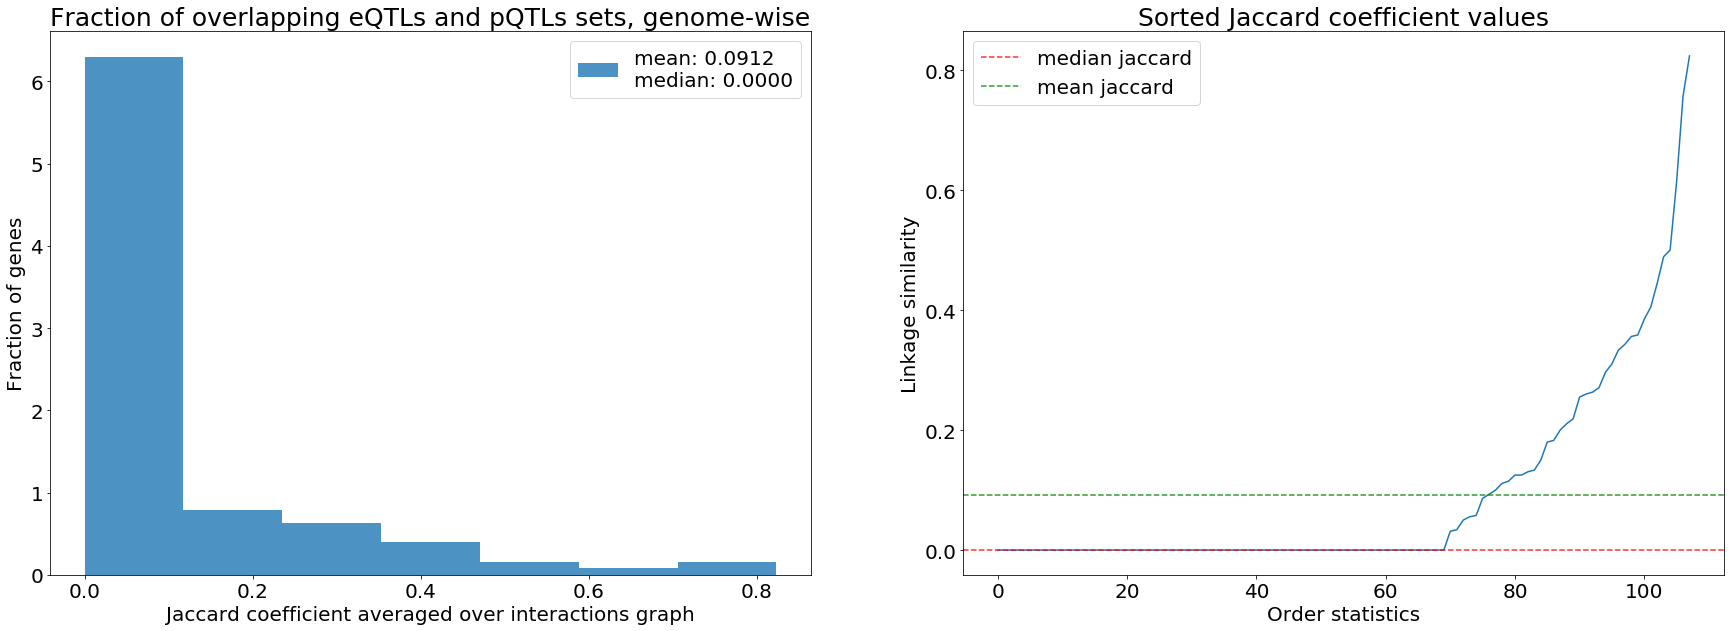

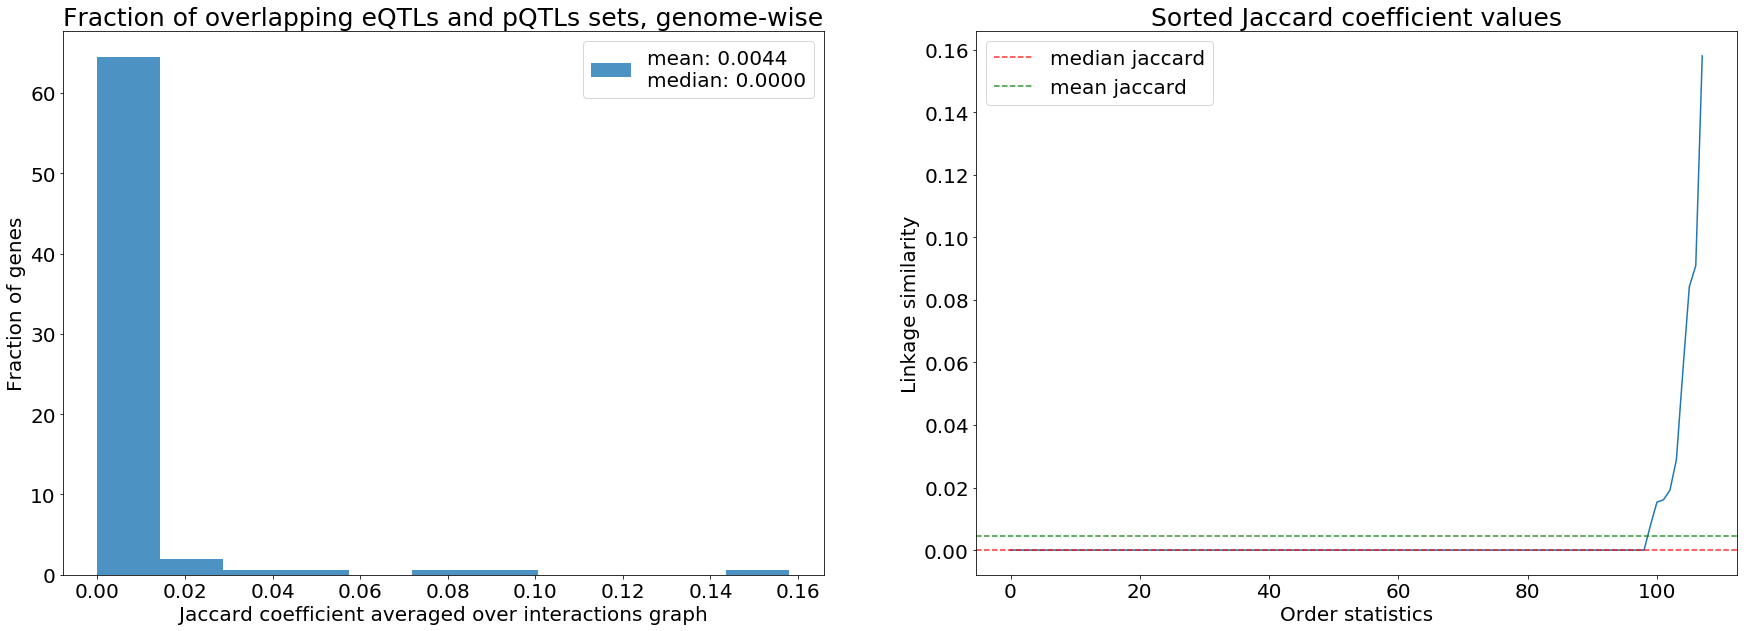

In [60]:
reload(qtls)

qtls.qtl_overlap_hist(kegg_module_intersection_j, "kegg_modules")
qtls.qtl_overlap_hist(kegg_module_randomized_intersection_j, "kegg_modules_randomized")

In [83]:
for simplify_flag in [False, True]: 
    display(pd.DataFrame(
        [(mname, mgraph.vcount(), mgraph.ecount()) for mname, mgraph in
         networks.basic_module_info(
             "kegg_modules", thecellmap_modules_dict, interaction_graphs_dict["all"], simplify_flag
         ).items()], 
        columns=["Module name", "Num. vertices", "Num. edges"]
    ).sort_values(by=["Num. vertices"], ascending=1))

,Module name,Num. vertices,Num. edges
28,"Polyamine biosynthesis, arginine to ornithine ...",2,3
15,Cap binding complex,2,24
99,"Cysteine biosynthesis, homocysteine + serine t...",2,4
5,ESCRT-0 complex,2,23
45,DNA polymerase zeta complex,2,8
76,"Phosphatidylcholine (PC) biosynthesis, PE to PC",2,10
105,"Nucleotide sugar biosynthesis, galactose to UD...",3,14
78,ESCRT-II complex,3,28
88,Ski complex,3,32
67,"Phosphatidylcholine (PC) biosynthesis, choline...",3,1


,Module name,Num. vertices,Num. edges
28,"Polyamine biosynthesis, arginine to ornithine ...",0,0
54,"Ornithine biosynthesis, glutamate to ornithine",0,0
67,"Phosphatidylcholine (PC) biosynthesis, choline...",0,0
49,"Phenylalanine biosynthesis, chorismate to phen...",0,0
79,"Phosphatidylethanolamine (PE) biosynthesis, et...",0,0
100,"Arginine biosynthesis, ornithine to arginine",0,0
95,"Histidine biosynthesis, PRPP to histidine",0,0
12,"Proline biosynthesis, glutamate to proline",0,0
86,"Assimilatory sulfate reduction, sulfate to H2S",2,1
83,"C5 isoprenoid biosynthesis, mevalonate pathway",2,1


In [ ]:
qtls.process_ontologies(
    database_name="kegg_modules",
    expression_dfs=[eQTLs_expression_df, pQTLs_expression_df],
    qtl_dfs=[eQTLs_df, pQTLs_df],
    qtl_types=["eQTLs", "pQTLs"],
    interactome_graph=interaction_graphs_dict["physical"],
    module_gene=thecellmap_modules_dict,
    q_thresholds=np.logspace(-5, -2, 10)
)

## Generalization: processing human data

## ModuleQTLs: concept introduction and rationale

In [150]:
has_linkages = collections.defaultdict(collections.Counter)
for qtl_type, qtl_df in [("eQTLs", eQTLs_df), ("pQTLs", pQTLs_df)]:
    for gene_name in tqdm(np.intersect1d(eQTLs_expression_df["gene"], pQTLs_expression_df["gene"])):
        has_linkages[qtl_type][len(qtls.linked_markers(qtl_df, [gene_name])) > 0] += 1
has_linkages

  0%|          | 0/1276 [00:00<?, ?it/s]

  9%|▊         | 111/1276 [00:00<00:01, 1108.37it/s]

 16%|█▌        | 202/1276 [00:00<00:01, 1000.99it/s]

 22%|██▏       | 278/1276 [00:00<00:01, 919.50it/s] 

 29%|██▉       | 370/1276 [00:00<00:00, 918.12it/s]

 36%|███▌      | 457/1276 [00:00<00:00, 907.64it/s]

 43%|████▎     | 554/1276 [00:00<00:00, 916.98it/s]

 52%|█████▏    | 665/1276 [00:00<00:00, 943.72it/s]

 61%|██████    | 776/1276 [00:00<00:00, 963.75it/s]

 71%|███████   | 909/1276 [00:00<00:00, 1003.67it/s]

 80%|███████▉  | 1019/1276 [00:01<00:00, 1013.16it/s]

 88%|████████▊ | 1127/1276 [00:01<00:00, 1005.19it/s]

 96%|█████████▋| 1231/1276 [00:01<00:00, 983.67it/s] 

100%|██████████| 1276/1276 [00:01<00:00, 982.56it/s]


  0%|          | 0/1276 [00:00<?, ?it/s]

 12%|█▏        | 147/1276 [00:00<00:00, 1467.41it/s]

 25%|██▍       | 318/1276 [00:00<00:00, 1586.99it/s]

 38%|███▊      | 483/1276 [00:00<00:00, 1607.03it/s]

 53%|█████▎    | 676/1276 [00:00<00:00, 1686.89it/s]

 68%|██████▊   | 863/1276 [00:00<00:00, 1721.52it/s]

 81%|████████  | 1032/1276 [00:00<00:00, 1715.32it/s]

 98%|█████████▊| 1247/1276 [00:00<00:00, 1777.10it/s]

100%|██████████| 1276/1276 [00:00<00:00, 1771.79it/s]

defaultdict(collections.Counter,
            {'eQTLs': Counter({False: 729, True: 547}),
             'pQTLs': Counter({False: 685, True: 591})})